In [1]:
import Pkg; Pkg.add("DifferentialEquations")
import Pkg; Pkg.add("Plots")
import Pkg; Pkg.add("Formatting")
import Pkg; Pkg.add("Catalyst")
import Pkg; Pkg.add("Noise")
import Pkg; Pkg.add("LinearAlgebra")
import Pkg; Pkg.add("Latexify")
import Pkg; Pkg.add("ModelingToolkit")
import Pkg; Pkg.add("PlotlyJS")
import Pkg; Pkg.add("MATLABDiffEq")
Pkg.add("StatsPlots")

_ = IJulia.clear_output(true)

0

In [2]:
using DifferentialEquations;
using Random;
using Plots;
using Formatting;
using LinearAlgebra;
using Noise;
using Catalyst;
using Latexify;
using MATLABDiffEq;
using StatsPlots;

# Globals

In [3]:
ALPHA = 1e-3
BETA = 1e-8

BASE_RATE = 1.0
BASE_CONC = 1.0

INFRATESCALE = 1e3
INFCONCSCALE = 1e4 # In 10nM order or something like that.

UNIMOL_K = BASE_RATE*ALPHA
BIMOL_K = 2*BASE_RATE*ALPHA/BETA

INFRATE = INFRATESCALE*BASE_RATE*ALPHA/BETA
INFCONC = INFCONCSCALE*BASE_CONC*BETA
LINKER_RATE=INFRATESCALE/INFCONCSCALE*BASE_RATE*ALPHA/BETA

NCAT = 3 # No. of catalytic reactions per each autocatalytic reaction

LEAK = 1
SHADOW = 0
LEAK_RATE = 1e-5

1.0e-5

# Utils

In [4]:
# Returns the sum of concentrations of the species with a given prefix
function aggregate_values(rn, odesol; prefix='x')
    ss = species(rn)

    ret = zeros(length(odesol[1, :]))
    total = 0
    for i in 1:length(ss)
        item = ss[i]
        item_str = "$item"
        if startswith(item_str, prefix)
#             println(item_str)
            ret += odesol[i, :] # Gets the variable at index i for all time steps.
        end
    end
    return ret
end


function print_species_array(reaction_network)
    ss = species(reaction_network)
    print("species = [")
    for s in ss
        print("'", s,"'", ",")
    end
    print("]")
    
end


function simulate(rn, u0, p; tspan=(0.0, 1000.0), reltol=1e-12, abstol=1e-12)
    oprob = ODEProblem(rn, u0, tspan, p)
    sol = solve(oprob, Rosenbrock23(), reltol=reltol, abstol=abstol)
    return sol
end

simulate (generic function with 1 method)

In [5]:
function simulation_results(rn,                         
                            u0,
                            p;
                            tspan=(0, 2.0),
                            track_prefix="x")
    sol = simulate(rn, u0, p, tspan=tspan)
    xs = sol.t
    ys = aggregate_values(rn, sol, prefix=track_prefix)
    return xs, ys
end

# TODO(rajiv): Try to fit all the ideal, cat, dna curves into the same plot by scaling!
function dna_simulation_results(dna_rn, 
                dna_u0, 
                dna_p; 
                tspan=(0, 6000), 
                leak_index=4, 
                shadow_index=6, 
                track_prefixes=["x"],
                abstol=1e-9,
                reltol=1e-9)
    
    dna_p_leak = deepcopy(dna_p)
    dna_p_leak[leak_index] = 1
    
    dna_p_leak_shadow = deepcopy(dna_p)
    dna_p_leak_shadow[leak_index] = 1
    dna_p_leak_shadow[shadow_index] = 1
    
    dna_sol = simulate(dna_rn, dna_u0, dna_p, tspan=tspan)
    dna_leak_sol = simulate(dna_rn, dna_u0, dna_p_leak, tspan=tspan)
    dna_leak_shadow_sol = simulate(dna_rn, dna_u0, dna_p_leak_shadow, tspan=tspan)
    xs = []
    ys = []
    labels = []
    for track_prefix in track_prefixes
        
        dna_output = aggregate_values(dna_rn, dna_sol, prefix=track_prefix)
        dna_leak_output = aggregate_values(dna_rn, dna_leak_sol, prefix=track_prefix)
        dna_leak_shadow_output = aggregate_values(dna_rn, dna_leak_shadow_sol, prefix=track_prefix)
        append!(xs, [dna_sol.t, dna_leak_sol.t, dna_leak_shadow_sol.t])
        append!(ys, [dna_output, dna_leak_output, dna_leak_shadow_output])
        append!(labels, ["$track_prefix leak:0|shadow:0" "$track_prefix leak:1|shadow:0" "$track_prefix leak:1|shadow:1"])
    end
    return xs, ys, labels
end

dna_simulation_results (generic function with 1 method)

# 1. Rock Paper Scissor Oscillator

## 1.1 Ideal

In [6]:
rps_ideal_rn = @reaction_network begin
    q, c + b --> c + c
    q, a + c --> a + a
    q, b + a --> b + b
end q

Model ##ReactionSystem#312
States (3):
  c(t)
  b(t)
  a(t)
Parameters (1):
  q

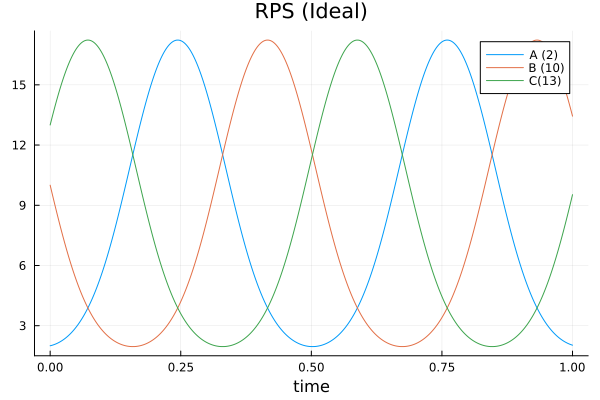

In [7]:
tspan = (0, 1)
ainit = 2
binit = 10
cinit = 13
u0 = [cinit, binit, ainit]
p = [1]
oprob = ODEProblem(rps_ideal_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

aplot = aggregate_values(rps_ideal_rn, sol, prefix="a")
bplot = aggregate_values(rps_ideal_rn, sol, prefix="b")
cplot = aggregate_values(rps_ideal_rn, sol, prefix="c")
t = sol.t
plot([t, t, t], [aplot, bplot, cplot], xlabel=:time, labels=["A (2)" "B (10)" "C(13)"], title="RPS (Ideal)", legend=:best)

In [8]:
savefig("images/rps_ideal.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/rps_ideal.png"

## 1.2 RPS (Leak = No Shadow = No)

In [9]:
rps_rn = @reaction_network begin
    q, c + gate_L_c_b --> buffer_H_c_b_leaks_c + BSbicb
    qmax, BSbicb + buffer_H_c_b_leaks_c --> c + gate_L_c_b
    qmax, b + buffer_H_c_b_leaks_c --> Ibicb
    qmax, Ibicb + gate_T_c_b_leaks_c_c --> c + c
    q, a + gate_L_a_c --> buffer_H_a_c_leaks_a + BSbiac
    qmax, BSbiac + buffer_H_a_c_leaks_a --> a + gate_L_a_c
    qmax, c + buffer_H_a_c_leaks_a --> Ibiac
    qmax, Ibiac + gate_T_a_c_leaks_a_a --> a + a
    q, b + gate_L_b_a --> buffer_H_b_a_leaks_b + BSbiba
    qmax, BSbiba + buffer_H_b_a_leaks_b --> b + gate_L_b_a
    qmax, a + buffer_H_b_a_leaks_b --> Ibiba
    qmax, Ibiba + gate_T_b_a_leaks_b_b --> b + b
end q qmax

Model ##ReactionSystem#314
States (18):
  c(t)
  gate_L_c_b(t)
  buffer_H_c_b_leaks_c(t)
  BSbicb(t)
  b(t)
  Ibicb(t)
⋮
Parameters (2):
  q
  qmax

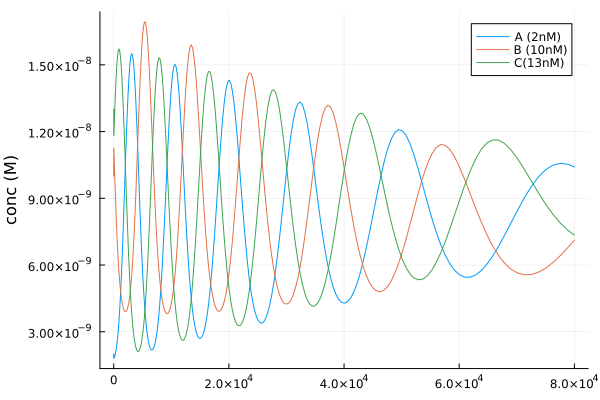

In [10]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

ainit = 2*1e-9
binit = 10*1e-9
cinit = 13*1e-9

Cmax = 200e-9 # 200nM

u0 = [
cinit, Cmax, 0.0, Cmax, binit, 
0.0, Cmax, ainit, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, 0.0, 
Cmax, 0.0, Cmax, 
]

p = [q, qmax]

tspan = (0, 80000)
oprob = ODEProblem(rps_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

aplot = aggregate_values(rps_rn, sol, prefix="a")
bplot = aggregate_values(rps_rn, sol, prefix="b")
cplot = aggregate_values(rps_rn, sol, prefix="c")
t = sol.t
plot([t, t, t], [aplot, bplot, cplot], ylabel="conc (M)", 
    labels=["A (2nM)" "B (10nM)" "C(13nM)"], legend=:topright)

In [11]:
savefig("images/rps_dsd.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/rps_dsd.png"

## 1.3 RPS (Leak = Yes, Shadow = No)

In [12]:
rps_rn = @reaction_network begin
    q, c + gate_L_c_b --> buffer_H_c_b_leaks_c + BSbicb
    qmax, BSbicb + buffer_H_c_b_leaks_c --> c + gate_L_c_b
    qmax, b + buffer_H_c_b_leaks_c --> Ibicb
    qmax, Ibicb + gate_T_c_b_leaks_c_c --> c + c
    q, a + gate_L_a_c --> buffer_H_a_c_leaks_a + BSbiac
    qmax, BSbiac + buffer_H_a_c_leaks_a --> a + gate_L_a_c
    qmax, c + buffer_H_a_c_leaks_a --> Ibiac
    qmax, Ibiac + gate_T_a_c_leaks_a_a --> a + a
    q, b + gate_L_b_a --> buffer_H_b_a_leaks_b + BSbiba
    qmax, BSbiba + buffer_H_b_a_leaks_b --> b + gate_L_b_a
    qmax, a + buffer_H_b_a_leaks_b --> Ibiba
    qmax, Ibiba + gate_T_b_a_leaks_b_b --> b + b
    
    # Leak reactions
    leak*leak_rate, 0 --> c + c
    leak*leak_rate, 0 --> a + a
    leak*leak_rate, 0 --> b + b
end q qmax leak leak_rate
print_species_array(rps_rn)

species = ['c(t)','gate_L_c_b(t)','buffer_H_c_b_leaks_c(t)','BSbicb(t)','b(t)','Ibicb(t)','gate_T_c_b_leaks_c_c(t)','a(t)','gate_L_a_c(t)','buffer_H_a_c_leaks_a(t)','BSbiac(t)','Ibiac(t)','gate_T_a_c_leaks_a_a(t)','gate_L_b_a(t)','buffer_H_b_a_leaks_b(t)','BSbiba(t)','Ibiba(t)','gate_T_b_a_leaks_b_b(t)',]

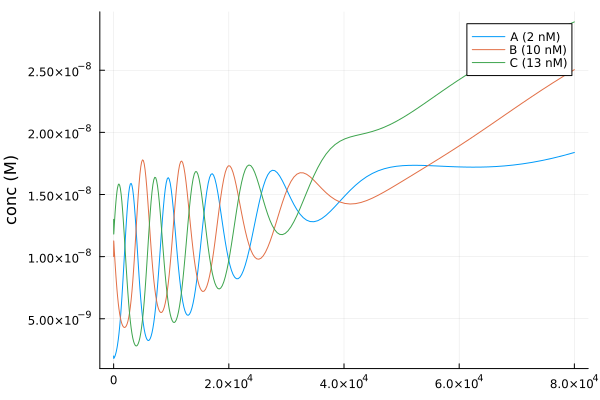

In [13]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

ainit = 2*1e-9
binit = 10*1e-9
cinit = 13*1e-9

Cmax = 200e-9 # 100nM

leak = 1
leak_rate = 1e-13 # 0.36 nM/hr 

u0 = [
cinit, Cmax, 0.0, Cmax, binit, 
0.0, Cmax, ainit, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, 0.0, 
Cmax, 0.0, Cmax, 
]

p = [q, qmax, leak, leak_rate]

tspan = (0, 80000)
oprob = ODEProblem(rps_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

aplot = aggregate_values(rps_rn, sol, prefix="a")
bplot = aggregate_values(rps_rn, sol, prefix="b")
cplot = aggregate_values(rps_rn, sol, prefix="c")
t = sol.t
plot([t, t, t], [aplot, bplot, cplot], labels=["A (2 nM)" "B (10 nM)" "C (13 nM)"], 
    legend=:topright, ylabel="conc (M)")

In [14]:
savefig("images/rps_leaky.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/rps_leaky.png"

## 1.4 RPS (Leaks = Yes, Shadow = Yes)

In [15]:
rps_rn = @reaction_network begin
    q, c + gate_L_c_b --> buffer_H_c_b_leaks_c + BSbicb
    shadow*q, shadow_c + shadow_gate_L_c_b --> shadow_buffer_H_c_b_leaks_c + shadow_BSbicb
    qmax, BSbicb + buffer_H_c_b_leaks_c --> c + gate_L_c_b
    shadow*qmax, shadow_BSbicb + shadow_buffer_H_c_b_leaks_c --> shadow_c + shadow_gate_L_c_b
    qmax, b + buffer_H_c_b_leaks_c --> Ibicb
    shadow*qmax, shadow_b + shadow_buffer_H_c_b_leaks_c --> shadow_Ibicb
    qmax, Ibicb + gate_T_c_b_leaks_c_c --> c + c
    shadow*qmax, shadow_Ibicb + shadow_gate_T_c_b_leaks_c_c --> shadow_c + shadow_c
    q, a + gate_L_a_c --> buffer_H_a_c_leaks_a + BSbiac
    shadow*q, shadow_a + shadow_gate_L_a_c --> shadow_buffer_H_a_c_leaks_a + shadow_BSbiac
    qmax, BSbiac + buffer_H_a_c_leaks_a --> a + gate_L_a_c
    shadow*qmax, shadow_BSbiac + shadow_buffer_H_a_c_leaks_a --> shadow_a + shadow_gate_L_a_c
    qmax, c + buffer_H_a_c_leaks_a --> Ibiac
    shadow*qmax, shadow_c + shadow_buffer_H_a_c_leaks_a --> shadow_Ibiac
    qmax, Ibiac + gate_T_a_c_leaks_a_a --> a + a
    shadow*qmax, shadow_Ibiac + shadow_gate_T_a_c_leaks_a_a --> shadow_a + shadow_a
    q, b + gate_L_b_a --> buffer_H_b_a_leaks_b + BSbiba
    shadow*q, shadow_b + shadow_gate_L_b_a --> shadow_buffer_H_b_a_leaks_b + shadow_BSbiba
    qmax, BSbiba + buffer_H_b_a_leaks_b --> b + gate_L_b_a
    shadow*qmax, shadow_BSbiba + shadow_buffer_H_b_a_leaks_b --> shadow_b + shadow_gate_L_b_a
    qmax, a + buffer_H_b_a_leaks_b --> Ibiba
    shadow*qmax, shadow_a + shadow_buffer_H_b_a_leaks_b --> shadow_Ibiba
    qmax, Ibiba + gate_T_b_a_leaks_b_b --> b + b
    shadow*qmax, shadow_Ibiba + shadow_gate_T_b_a_leaks_b_b --> shadow_b + shadow_b
    
    # Leak reactions
    leak*leak_rate, 0 --> c + c
    leak*leak_rate, 0 --> a + a
    leak*leak_rate, 0 --> b + b
    
    # Shadow leaks
    shadow*leak*leak_rate, 0 --> shadow_c + shadow_c
    shadow*leak*leak_rate, 0 --> shadow_a + shadow_a
    shadow*leak*leak_rate, 0 --> shadow_b + shadow_b
    
    # Annihilation
    shadow*leak*annih, shadow_a + a --> 0
    shadow*leak*annih, shadow_b + b --> 0
    shadow*leak*annih, shadow_c + c --> 0
    
    
end q qmax leak leak_rate shadow annih
print_species_array(rps_rn)

species = ['c(t)','gate_L_c_b(t)','buffer_H_c_b_leaks_c(t)','BSbicb(t)','shadow_c(t)','shadow_gate_L_c_b(t)','shadow_buffer_H_c_b_leaks_c(t)','shadow_BSbicb(t)','b(t)','Ibicb(t)','shadow_b(t)','shadow_Ibicb(t)','gate_T_c_b_leaks_c_c(t)','shadow_gate_T_c_b_leaks_c_c(t)','a(t)','gate_L_a_c(t)','buffer_H_a_c_leaks_a(t)','BSbiac(t)','shadow_a(t)','shadow_gate_L_a_c(t)','shadow_buffer_H_a_c_leaks_a(t)','shadow_BSbiac(t)','Ibiac(t)','shadow_Ibiac(t)','gate_T_a_c_leaks_a_a(t)','shadow_gate_T_a_c_leaks_a_a(t)','gate_L_b_a(t)','buffer_H_b_a_leaks_b(t)','BSbiba(t)','shadow_gate_L_b_a(t)','shadow_buffer_H_b_a_leaks_b(t)','shadow_BSbiba(t)','Ibiba(t)','shadow_Ibiba(t)','gate_T_b_a_leaks_b_b(t)','shadow_gate_T_b_a_leaks_b_b(t)',]

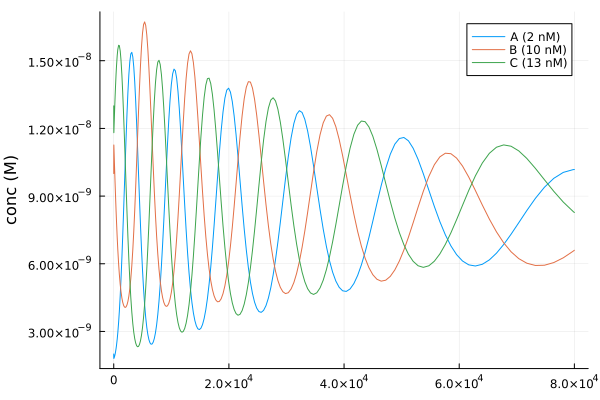

In [16]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

ainit = 2*1e-9
binit = 10*1e-9
cinit = 13*1e-9

Cmax = 200e-9 # 200nM

leak = 1
leak_rate = 1e-13 # M/sec equivalent to 0.36 nM/hr 
shadow = 1
# Taken from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5739081/ It could be 1e7 as well.
annih = 5e5

u0 = [
cinit, Cmax, 0.0, Cmax, 0.0, 
Cmax, 0.0, Cmax, binit, 0.0, 
0.0, 0.0, Cmax, Cmax, ainit, 
Cmax, 0.0, Cmax, 0.0, Cmax, 
0.0, Cmax, 0.0, 0.0, Cmax, 
Cmax, Cmax, 0.0, Cmax, Cmax, 
0.0, Cmax, 0.0, 0.0, Cmax, 
Cmax, 
]

p = [q, qmax, leak, leak_rate, shadow, annih]

tspan = (0, 80000)
oprob = ODEProblem(rps_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

aplot = aggregate_values(rps_rn, sol, prefix="a")
bplot = aggregate_values(rps_rn, sol, prefix="b")
cplot = aggregate_values(rps_rn, sol, prefix="c")
t = sol.t
plot([t, t, t], [aplot, bplot, cplot], labels=["A (2 nM)" "B (10 nM)" "C (13 nM)"], 
    legend=:topright, ylabel="conc (M)")

In [42]:
savefig("images/rps_leaky_shadow.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/rps_leaky_shadow.png"

## RPS Oscillator (Leaks=Yes | Shadow = Yes) + Buffering

In [43]:
rps_rn = @reaction_network begin
    q, c + gate_L_c_b --> buffer_H_c_b_leaks_c + BSbicb
    shadow*q, shadow_c + shadow_gate_L_c_b --> shadow_buffer_H_c_b_leaks_c + shadow_BSbicb
    qmax, BSbicb + buffer_H_c_b_leaks_c --> c + gate_L_c_b
    shadow*qmax, shadow_BSbicb + shadow_buffer_H_c_b_leaks_c --> shadow_c + shadow_gate_L_c_b
    qmax, b + buffer_H_c_b_leaks_c --> Ibicb
    shadow*qmax, shadow_b + shadow_buffer_H_c_b_leaks_c --> shadow_Ibicb
    qmax, Ibicb + gate_T_c_b_leaks_c_c --> c + c
    shadow*qmax, shadow_Ibicb + shadow_gate_T_c_b_leaks_c_c --> shadow_c + shadow_c
    q, a + gate_L_a_c --> buffer_H_a_c_leaks_a + BSbiac
    shadow*q, shadow_a + shadow_gate_L_a_c --> shadow_buffer_H_a_c_leaks_a + shadow_BSbiac
    qmax, BSbiac + buffer_H_a_c_leaks_a --> a + gate_L_a_c
    shadow*qmax, shadow_BSbiac + shadow_buffer_H_a_c_leaks_a --> shadow_a + shadow_gate_L_a_c
    qmax, c + buffer_H_a_c_leaks_a --> Ibiac
    shadow*qmax, shadow_c + shadow_buffer_H_a_c_leaks_a --> shadow_Ibiac
    qmax, Ibiac + gate_T_a_c_leaks_a_a --> a + a
    shadow*qmax, shadow_Ibiac + shadow_gate_T_a_c_leaks_a_a --> shadow_a + shadow_a
    q, b + gate_L_b_a --> buffer_H_b_a_leaks_b + BSbiba
    shadow*q, shadow_b + shadow_gate_L_b_a --> shadow_buffer_H_b_a_leaks_b + shadow_BSbiba
    qmax, BSbiba + buffer_H_b_a_leaks_b --> b + gate_L_b_a
    shadow*qmax, shadow_BSbiba + shadow_buffer_H_b_a_leaks_b --> shadow_b + shadow_gate_L_b_a
    qmax, a + buffer_H_b_a_leaks_b --> Ibiba
    shadow*qmax, shadow_a + shadow_buffer_H_b_a_leaks_b --> shadow_Ibiba
    qmax, Ibiba + gate_T_b_a_leaks_b_b --> b + b
    shadow*qmax, shadow_Ibiba + shadow_gate_T_b_a_leaks_b_b --> shadow_b + shadow_b
    
    # Leak reactions
    leak*leak_rate, 0 --> c + c
    leak*leak_rate, 0 --> a + a
    leak*leak_rate, 0 --> b + b
    
    # Shadow leaks
    shadow*leak*leak_rate, 0 --> shadow_c + shadow_c
    shadow*leak*leak_rate, 0 --> shadow_a + shadow_a
    shadow*leak*leak_rate, 0 --> shadow_b + shadow_b
    
    # Annihilation
    shadow*leak*annih, shadow_a + a --> 0
    shadow*leak*annih, shadow_b + b --> 0
    shadow*leak*annih, shadow_c + c --> 0
    
    # Buffering
    buffer, 0 --> gate_L_c_b
    buffer, 0 --> shadow_gate_L_c_b
    buffer, 0 --> BSbicb
    buffer, 0 --> shadow_BSbicb
    buffer, 0 --> gate_T_c_b_leaks_c_c
    buffer, 0 --> shadow_gate_T_c_b_leaks_c_c
    
    buffer, 0 --> gate_L_a_c
    buffer, 0 --> shadow_gate_L_a_c
    buffer, 0 --> BSbiac
    buffer, 0 --> shadow_BSbiac
    buffer, 0 --> gate_T_a_c_leaks_a_a
    buffer, 0 --> shadow_gate_T_a_c_leaks_a_a
    
    buffer, 0 --> gate_L_b_a
    buffer, 0 --> shadow_gate_L_b_a
    buffer, 0 --> BSbiba
    buffer, 0 --> shadow_BSbiba
    buffer, 0 --> gate_T_b_a_leaks_b_b
    buffer, 0 --> shadow_gate_T_b_a_leaks_b_b
    
    
end q qmax leak leak_rate shadow annih buffer
print_species_array(rps_rn)

species = ['c(t)','gate_L_c_b(t)','buffer_H_c_b_leaks_c(t)','BSbicb(t)','shadow_c(t)','shadow_gate_L_c_b(t)','shadow_buffer_H_c_b_leaks_c(t)','shadow_BSbicb(t)','b(t)','Ibicb(t)','shadow_b(t)','shadow_Ibicb(t)','gate_T_c_b_leaks_c_c(t)','shadow_gate_T_c_b_leaks_c_c(t)','a(t)','gate_L_a_c(t)','buffer_H_a_c_leaks_a(t)','BSbiac(t)','shadow_a(t)','shadow_gate_L_a_c(t)','shadow_buffer_H_a_c_leaks_a(t)','shadow_BSbiac(t)','Ibiac(t)','shadow_Ibiac(t)','gate_T_a_c_leaks_a_a(t)','shadow_gate_T_a_c_leaks_a_a(t)','gate_L_b_a(t)','buffer_H_b_a_leaks_b(t)','BSbiba(t)','shadow_gate_L_b_a(t)','shadow_buffer_H_b_a_leaks_b(t)','shadow_BSbiba(t)','Ibiba(t)','shadow_Ibiba(t)','gate_T_b_a_leaks_b_b(t)','shadow_gate_T_b_a_leaks_b_b(t)',]

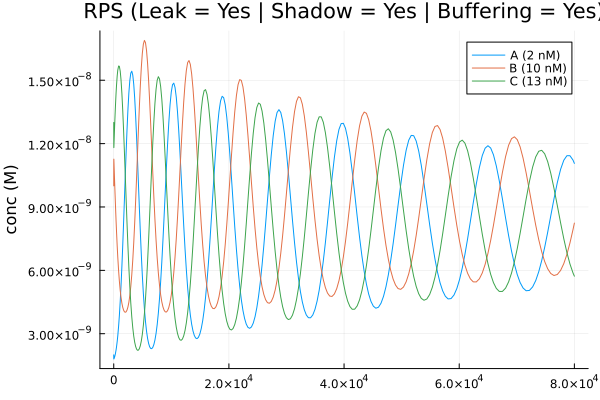

In [44]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

ainit = 2*1e-9
binit = 10*1e-9
cinit = 13*1e-9

Cmax = 200e-9 # 200nM

leak = 1
leak_rate = 1e-13 # M/sec equivalent to 0.36 nM/hr 
shadow = 1
# Taken from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5739081/ It could be 1e7 as well.
annih = 1e6

# Buffering
buffer = 2.78e-12

u0 = [
cinit, Cmax, 0.0, Cmax, 0.0, 
Cmax, 0.0, Cmax, binit, 0.0, 
0.0, 0.0, Cmax, Cmax, ainit, 
Cmax, 0.0, Cmax, 0.0, Cmax, 
0.0, Cmax, 0.0, 0.0, Cmax, 
Cmax, Cmax, 0.0, Cmax, Cmax, 
0.0, Cmax, 0.0, 0.0, Cmax, 
Cmax, 
]

p = [q, qmax, leak, leak_rate, shadow, annih, buffer]

tspan = (0, 80000)
oprob = ODEProblem(rps_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

aplot = aggregate_values(rps_rn, sol, prefix="a")
bplot = aggregate_values(rps_rn, sol, prefix="b")
cplot = aggregate_values(rps_rn, sol, prefix="c")
gate_plot = aggregate_values(rps_rn, sol, prefix="gate_L_c_b")
t = sol.t
plot([t, t, t], [aplot, bplot, cplot], labels=["A (2 nM)" "B (10 nM)" "C (13 nM)"], 
    legend=:best, ylabel="conc (M)", title="RPS (Leak = Yes | Shadow = Yes | Buffering = Yes)")


In [45]:
savefig("images/rps_leaky_shadow_buffering.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/rps_leaky_shadow_buffering.png"

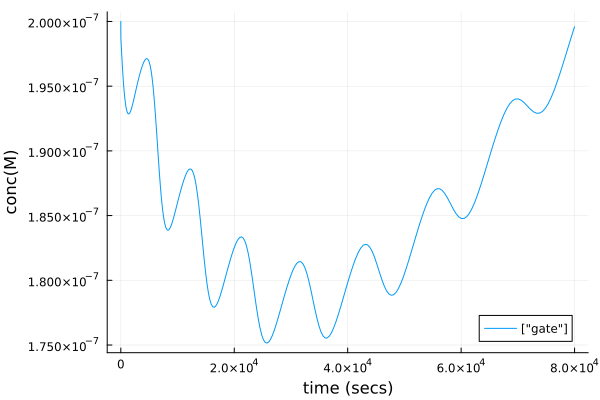

In [46]:
plot(t, gate_plot, yticks=:true, ylabel=:"conc(M)", xlabel=:"time (secs)", labels=["gate"], legend=:bottomright)

In [47]:
savefig("images/buffering_gate.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/buffering_gate.png"

# 2. Consensus

## 2.1 Ideal

In [48]:
consensus_ideal_rn = @reaction_network begin 
    1, a + b --> y + y
    1, a + y --> a + a
    1, b + y --> b + b
end

Model ##ReactionSystem#351
States (3):
  a(t)
  b(t)
  y(t)
Parameters (0):

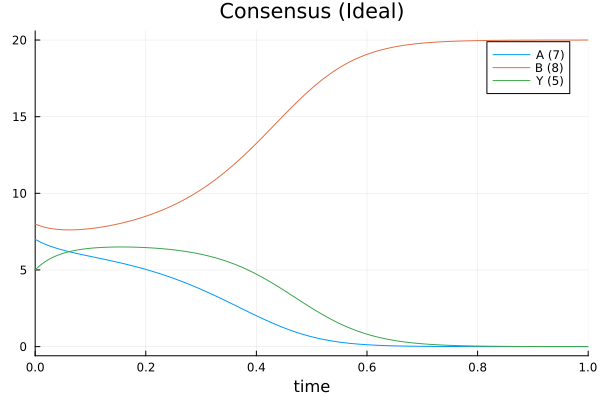

In [49]:
plot()
ainit = 7
binit = 8
yinit = 5


u0 = [ainit, binit, yinit]
p = []
tspan = (0, 1)
oprob = ODEProblem(consensus_ideal_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)
plot(sol, labels=["A (7)" "B (8)" "Y (5)"], xlabel="time", title="Consensus (Ideal)", legend=:best)

In [50]:
savefig("images/consensus_ideal.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/consensus_ideal.png"

## 2.2 Consensus (Leak = No, Shadow = No)

In [51]:
consensus_rn = @reaction_network begin
    q1, a + gate_L_a_b --> buffer_H_a_b_leaks_a + BSbiab
    qmax, BSbiab + buffer_H_a_b_leaks_a --> a + gate_L_a_b
    qmax, b + buffer_H_a_b_leaks_a --> Ibiab
    qmax, Ibiab + gate_T_a_b_leaks_y_y --> y + y
    q2, a + gate_L_a_y --> buffer_H_a_y_leaks_a + BSbiay
    qmax, BSbiay + buffer_H_a_y_leaks_a --> a + gate_L_a_y
    qmax, y + buffer_H_a_y_leaks_a --> Ibiay
    qmax, Ibiay + gate_T_a_y_leaks_a_a --> a + a
    q3, b + gate_L_b_y --> buffer_H_b_y_leaks_b + BSbiby
    qmax, BSbiby + buffer_H_b_y_leaks_b --> b + gate_L_b_y
    qmax, y + buffer_H_b_y_leaks_b --> Ibiby
    qmax, Ibiby + gate_T_b_y_leaks_b_b --> b + b
    
    # Additional buffering to adjust
    qsb, b + gate_LS_b --> buffer_HS_b_leaks_b + BSbib
    qmax, buffer_HS_b_leaks_b + BSbib --> b + gate_LS_b
    
    qsy, y + gate_LS_y --> buffer_HS_y_leaks_y + BSbiy
    qmax, buffer_HS_y_leaks_y + BSbiy --> y + gate_LS_y
    
end q1 q2 q3 qmax qsb qsy

Model ##ReactionSystem#354
States (24):
  a(t)
  gate_L_a_b(t)
  buffer_H_a_b_leaks_a(t)
  BSbiab(t)
  b(t)
  Ibiab(t)
⋮
Parameters (6):
  q1
  q2
  q3
  qmax
  qsb
  qsy

In [52]:
print_species_array(consensus_rn)

species = ['a(t)','gate_L_a_b(t)','buffer_H_a_b_leaks_a(t)','BSbiab(t)','b(t)','Ibiab(t)','gate_T_a_b_leaks_y_y(t)','y(t)','gate_L_a_y(t)','buffer_H_a_y_leaks_a(t)','BSbiay(t)','Ibiay(t)','gate_T_a_y_leaks_a_a(t)','gate_L_b_y(t)','buffer_H_b_y_leaks_b(t)','BSbiby(t)','Ibiby(t)','gate_T_b_y_leaks_b_b(t)','gate_LS_b(t)','buffer_HS_b_leaks_b(t)','BSbib(t)','gate_LS_y(t)','buffer_HS_y_leaks_y(t)','BSbiy(t)',]

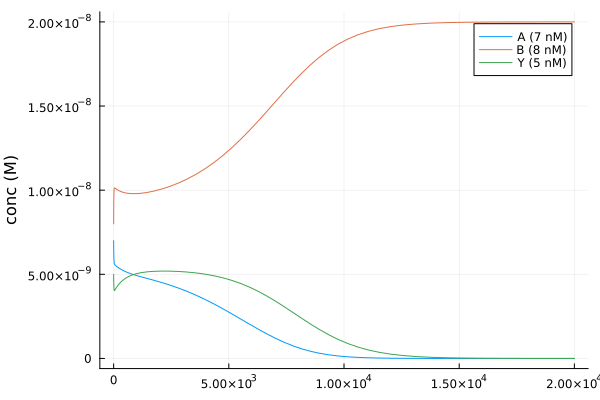

In [53]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled. 1/(1e3*1e-8)

sigma = 2*k # sigma_a = 2k, sigma_b = k, sigma_y = 0
sigma_a = 2*k
sigma_b = k
sigma_y = 0

gamma_inv = qmax/(qmax-sigma) # 1e6/(8*1e5) = 5/4
q1 = gamma_inv*k
q2 = gamma_inv*k
q3 = gamma_inv*k
qsb = gamma_inv*k
qsy = gamma_inv*2*k

ainit = gamma_inv*7*1e-9
binit = gamma_inv*8*1e-9
yinit = gamma_inv*5*1e-9

Cmax = 100e-9 # 100nM


u0 = [
ainit, Cmax, 0.0, Cmax, binit, 
0.0, Cmax, yinit, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, 0.0, 
Cmax, Cmax, 0.0, Cmax, 
]

p = [q1, q2, q3, qmax, qsb, qsy]

tspan = (0, 20000)
oprob = ODEProblem(consensus_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)
aplot = aggregate_values(consensus_rn, sol, prefix="a")/gamma_inv
bplot = aggregate_values(consensus_rn, sol, prefix="b")/gamma_inv
yplot = aggregate_values(consensus_rn, sol, prefix="y")/gamma_inv
t = sol.t
plot([t, t, t], [aplot, bplot, yplot], ylabel="conc (M)", 
    labels=["A (7 nM)" "B (8 nM)" "Y (5 nM)"]
    , legend=:topright)
# bsbib = aggregate_values(consensus_dsd_rn, sol, prefix="BSbib")
# plot(bsbib)

In [54]:
savefig("images/consensus_dsd.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/consensus_dsd.png"

## 2.3 Consensus (Leak = Yes, Shadow = No)

In [55]:
consensus_rn = @reaction_network begin
    q1, a + gate_L_a_b --> buffer_H_a_b_leaks_a + BSbiab
    qmax, BSbiab + buffer_H_a_b_leaks_a --> a + gate_L_a_b
    qmax, b + buffer_H_a_b_leaks_a --> Ibiab
    qmax, Ibiab + gate_T_a_b_leaks_y_y --> y + y
    q2, a + gate_L_a_y --> buffer_H_a_y_leaks_a + BSbiay
    qmax, BSbiay + buffer_H_a_y_leaks_a --> a + gate_L_a_y
    qmax, y + buffer_H_a_y_leaks_a --> Ibiay
    qmax, Ibiay + gate_T_a_y_leaks_a_a --> a + a
    q3, b + gate_L_b_y --> buffer_H_b_y_leaks_b + BSbiby
    qmax, BSbiby + buffer_H_b_y_leaks_b --> b + gate_L_b_y
    qmax, y + buffer_H_b_y_leaks_b --> Ibiby
    qmax, Ibiby + gate_T_b_y_leaks_b_b --> b + b
    
    # Additional buffering to adjust
    qsb, b + gate_LS_b --> buffer_HS_b_leaks_b + BSbib
    qmax, buffer_HS_b_leaks_b + BSbib --> b + gate_LS_b
    
    qsy, y + gate_LS_y --> buffer_HS_y_leaks_y + BSbiy
    qmax, buffer_HS_y_leaks_y + BSbiy --> y + gate_LS_y
    
    # Leak reactions
    leak*leak_rate, 0 --> y + y
    leak*leak_rate, 0 --> b + b
    leak*leak_rate, 0 --> a + a
    
    
end q1 q2 q3 qmax qsb qsy leak leak_rate

Model ##ReactionSystem#357
States (24):
  a(t)
  gate_L_a_b(t)
  buffer_H_a_b_leaks_a(t)
  BSbiab(t)
  b(t)
  Ibiab(t)
⋮
Parameters (8):
  q1
  q2
  q3
  qmax
  qsb
  qsy
⋮

In [56]:
print_species_array(consensus_rn)

species = ['a(t)','gate_L_a_b(t)','buffer_H_a_b_leaks_a(t)','BSbiab(t)','b(t)','Ibiab(t)','gate_T_a_b_leaks_y_y(t)','y(t)','gate_L_a_y(t)','buffer_H_a_y_leaks_a(t)','BSbiay(t)','Ibiay(t)','gate_T_a_y_leaks_a_a(t)','gate_L_b_y(t)','buffer_H_b_y_leaks_b(t)','BSbiby(t)','Ibiby(t)','gate_T_b_y_leaks_b_b(t)','gate_LS_b(t)','buffer_HS_b_leaks_b(t)','BSbib(t)','gate_LS_y(t)','buffer_HS_y_leaks_y(t)','BSbiy(t)',]

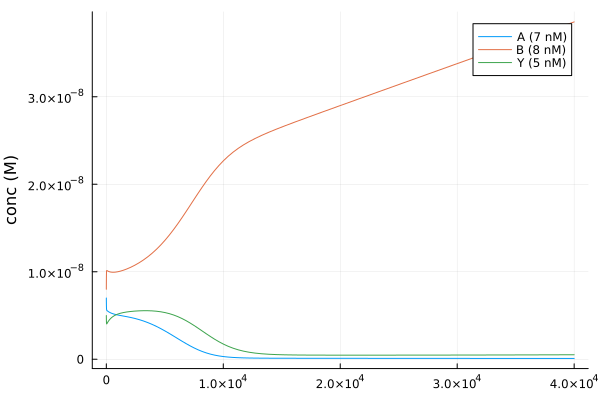

In [58]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled. 1/(1e3*1e-8)

sigma = 2*k # sigma_a = 2k, sigma_b = k, sigma_y = 0
sigma_a = 2*k
sigma_b = k
sigma_y = 0

gamma_inv = qmax/(qmax-sigma) # 1e6/(8*1e5) = 5/4
q1 = gamma_inv*k
q2 = gamma_inv*k
q3 = gamma_inv*k
qsb = gamma_inv*k
qsy = gamma_inv*2*k

ainit = gamma_inv*7*1e-9
binit = gamma_inv*8*1e-9
yinit = gamma_inv*5*1e-9

Cmax = 100e-9 # 100nM

leak = 1
leak_rate = 1e-13 # M/sec or 0.36 nM/hr


u0 = [
ainit, Cmax, 0.0, Cmax, binit, 
0.0, Cmax, yinit, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, 0.0, 
Cmax, Cmax, 0.0, Cmax, 
]

p = [q1, q2, q3, qmax, qsb, qsy, leak, leak_rate]

tspan = (0, 40000)
oprob = ODEProblem(consensus_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)
aplot = aggregate_values(consensus_rn, sol, prefix="a")/gamma_inv
bplot = aggregate_values(consensus_rn, sol, prefix="b")/gamma_inv
yplot = aggregate_values(consensus_rn, sol, prefix="y")/gamma_inv
t = sol.t
plot([t, t, t], [aplot, bplot, yplot], ylabel="conc (M)",  
    labels=["A (7 nM)" "B (8 nM)" "Y (5 nM)"], legend=:topright)

In [59]:
savefig("images/consensus_leaky.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/consensus_leaky.png"

## 2.4 Consensus (Leak = Yes, Shadow = Yes)

In [60]:
consensus_rn = @reaction_network begin
    q1, a + gate_L_a_b --> buffer_H_a_b_leaks_a + BSbiab
    shadow*q1, shadow_a + shadow_gate_L_a_b --> shadow_buffer_H_a_b_leaks_a + shadow_BSbiab
    qmax, BSbiab + buffer_H_a_b_leaks_a --> a + gate_L_a_b
    shadow*qmax, shadow_BSbiab + shadow_buffer_H_a_b_leaks_a --> shadow_a + shadow_gate_L_a_b
    qmax, b + buffer_H_a_b_leaks_a --> Ibiab
    shadow*qmax, shadow_b + shadow_buffer_H_a_b_leaks_a --> shadow_Ibiab
    qmax, Ibiab + gate_T_a_b_leaks_y_y --> y + y
    shadow*qmax, shadow_Ibiab + shadow_gate_T_a_b_leaks_y_y --> shadow_y + shadow_y
    q2, a + gate_L_a_y --> buffer_H_a_y_leaks_a + BSbiay
    shadow*q2, shadow_a + shadow_gate_L_a_y --> shadow_buffer_H_a_y_leaks_a + shadow_BSbiay
    qmax, BSbiay + buffer_H_a_y_leaks_a --> a + gate_L_a_y
    shadow*qmax, shadow_BSbiay + shadow_buffer_H_a_y_leaks_a --> shadow_a + shadow_gate_L_a_y
    qmax, y + buffer_H_a_y_leaks_a --> Ibiay
    shadow*qmax, shadow_y + shadow_buffer_H_a_y_leaks_a --> shadow_Ibiay
    qmax, Ibiay + gate_T_a_y_leaks_a_a --> a + a
    shadow*qmax, shadow_Ibiay + shadow_gate_T_a_y_leaks_a_a --> shadow_a + shadow_a
    q3, b + gate_L_b_y --> buffer_H_b_y_leaks_b + BSbiby
    shadow*q3, shadow_b + shadow_gate_L_b_y --> shadow_buffer_H_b_y_leaks_b + shadow_BSbiby
    qmax, BSbiby + buffer_H_b_y_leaks_b --> b + gate_L_b_y
    shadow*qmax, shadow_BSbiby + shadow_buffer_H_b_y_leaks_b --> shadow_b + shadow_gate_L_b_y
    qmax, y + buffer_H_b_y_leaks_b --> Ibiby
    shadow*qmax, shadow_y + shadow_buffer_H_b_y_leaks_b --> shadow_Ibiby
    qmax, Ibiby + gate_T_b_y_leaks_b_b --> b + b
    shadow*qmax, shadow_Ibiby + shadow_gate_T_b_y_leaks_b_b --> shadow_b + shadow_b
    
    # Additional buffering to adjust
    qsb, b + gate_LS_b --> buffer_HS_b_leaks_b + BSbib
    leak*shadow*qsb, shadow_b + shadow_gate_LS_b --> shadow_buffer_HS_b_leaks_b + shadow_BSbib
    qmax, buffer_HS_b_leaks_b + BSbib --> b + gate_LS_b
    leak*shadow*qmax, shadow_buffer_HS_b_leaks_b + shadow_BSbib --> shadow_b + shadow_gate_LS_b
    
    qsy, y + gate_LS_y --> buffer_HS_y_leaks_y + BSbiy
    qmax, buffer_HS_y_leaks_y + BSbiy --> y + gate_LS_y
    leak*shadow*qsy, shadow_y + shadow_gate_LS_y --> shadow_buffer_HS_y_leaks_y + shadow_BSbiy
    leak*shadow*qmax, shadow_buffer_HS_y_leaks_y + shadow_BSbiy --> shadow_y + shadow_gate_LS_y
    
    # Leak reactions
    leak*leak_rate, 0 --> y + y
    leak*leak_rate, 0 --> b + b
    leak*leak_rate, 0 --> a + a
    
    # Shadow leak reactions
    shadow*leak*leak_rate, 0 --> shadow_y + shadow_y
    shadow*leak*leak_rate, 0 --> shadow_b + shadow_b
    shadow*leak*leak_rate, 0 --> shadow_a + shadow_a
    
    # Leak cancellation
    shadow*leak*annih, shadow_a + a --> 0
    shadow*leak*annih, shadow_b + b --> 0
    shadow*leak*annih, shadow_y + y --> 0
    
end q1 q2 q3 qmax qsb qsy leak leak_rate shadow annih

Model ##ReactionSystem#362
States (48):
  a(t)
  gate_L_a_b(t)
  buffer_H_a_b_leaks_a(t)
  BSbiab(t)
  shadow_a(t)
  shadow_gate_L_a_b(t)
⋮
Parameters (10):
  q1
  q2
  q3
  qmax
  qsb
  qsy
⋮

In [61]:
print_species_array(consensus_rn)

species = ['a(t)','gate_L_a_b(t)','buffer_H_a_b_leaks_a(t)','BSbiab(t)','shadow_a(t)','shadow_gate_L_a_b(t)','shadow_buffer_H_a_b_leaks_a(t)','shadow_BSbiab(t)','b(t)','Ibiab(t)','shadow_b(t)','shadow_Ibiab(t)','gate_T_a_b_leaks_y_y(t)','y(t)','shadow_gate_T_a_b_leaks_y_y(t)','shadow_y(t)','gate_L_a_y(t)','buffer_H_a_y_leaks_a(t)','BSbiay(t)','shadow_gate_L_a_y(t)','shadow_buffer_H_a_y_leaks_a(t)','shadow_BSbiay(t)','Ibiay(t)','shadow_Ibiay(t)','gate_T_a_y_leaks_a_a(t)','shadow_gate_T_a_y_leaks_a_a(t)','gate_L_b_y(t)','buffer_H_b_y_leaks_b(t)','BSbiby(t)','shadow_gate_L_b_y(t)','shadow_buffer_H_b_y_leaks_b(t)','shadow_BSbiby(t)','Ibiby(t)','shadow_Ibiby(t)','gate_T_b_y_leaks_b_b(t)','shadow_gate_T_b_y_leaks_b_b(t)','gate_LS_b(t)','buffer_HS_b_leaks_b(t)','BSbib(t)','shadow_gate_LS_b(t)','shadow_buffer_HS_b_leaks_b(t)','shadow_BSbib(t)','gate_LS_y(t)','buffer_HS_y_leaks_y(t)','BSbiy(t)','shadow_gate_LS_y(t)','shadow_buffer_HS_y_leaks_y(t)','shadow_BSbiy(t)',]

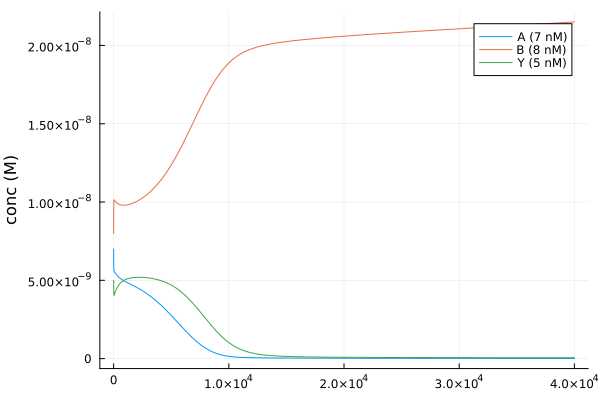

In [63]:
plot()

qmax = 1e6 # /M sec
k = 1e5 # scaled. 1/(1e3*1e-8)

sigma = 2*k # sigma_a = 2k, sigma_b = k, sigma_y = 0
sigma_a = 2*k
sigma_b = k
sigma_y = 0

gamma_inv = qmax/(qmax-sigma) # 1e6/(8*1e5) = 5/4
q1 = gamma_inv*k
q2 = gamma_inv*k
q3 = gamma_inv*k
qsb = gamma_inv*k
qsy = gamma_inv*2*k

ainit = gamma_inv*7*1e-9
binit = gamma_inv*8*1e-9
yinit = gamma_inv*5*1e-9

Cmax = 100e-9 # 100nM

leak = 1
leak_rate = 1e-13 # M/sec equivalent to 0.36 nM/hr 
shadow = 1
# Taken from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5739081/ It could be 1e7 as well.
annih = 1e7

u0 = [
ainit, Cmax, 0.0, Cmax, 0.0, 
Cmax, 0.0, Cmax, binit, 0.0, 
0.0, 0.0, Cmax, yinit, Cmax, 
0.0, Cmax, 0.0, Cmax, Cmax, 
0.0, Cmax, 0.0, 0.0, Cmax, 
Cmax, Cmax, 0.0, Cmax, Cmax, 
0.0, Cmax, 0.0, 0.0, Cmax, 
Cmax, Cmax, 0.0, Cmax, Cmax, 
0.0, Cmax, Cmax, 0.0, Cmax, 
Cmax, 0.0, Cmax, 
]

p = [q1, q2, q3, qmax, qsb, qsy, leak, leak_rate, shadow, annih]

tspan = (0, 40000)
oprob = ODEProblem(consensus_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)
aplot = aggregate_values(consensus_rn, sol, prefix="a")/gamma_inv
bplot = aggregate_values(consensus_rn, sol, prefix="b")/gamma_inv
yplot = aggregate_values(consensus_rn, sol, prefix="y")/gamma_inv
t = sol.t
plot([t, t, t], [aplot, bplot, yplot], ylabel="conc (M)",  
    labels=["A (7 nM)" "B (8 nM)" "Y (5 nM)"], legend=:topright)


In [64]:
savefig("images/consensus_leaky_shadow.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/consensus_leaky_shadow.png"

# 3. Control

## 3.1 Ideal

In [18]:
control_ideal_rn = @reaction_network begin
    ## Controller
    # Integration term
    cat, ep --> ep + xp
    cat, em --> em + xm
    
    # Proportional term summation
    kicat, xp --> xp + vp
    kicat, xm --> xm + vm
    kpcat, ep --> ep + vp
    kpcat, em --> em + vm
    deg, vp --> 0
    deg, vm --> 0
    
    # Error difference
    cat, rp --> rp + ep
    cat, rm --> rm + em
    cat, yp --> yp + em
    cat, ym --> ym + ep
    deg, ep --> 0
    deg, em --> 0
    
    ## Plant
    produce, vp --> vp + yp
    produce, vm --> vm + ym
    consume, yp --> 0
    consume, ym --> 0
    load, yp + loadp --> loadp
    load, ym + loadm --> loadm 
    
    ## Annihilations
    ann, xp + xm --> 0
    ann, ep + em --> 0
    ann, yp + ym --> 0
    ann, vp + vm --> 0
    ann, rp + rm --> 0
    ann, loadp + loadm --> 0
    
end cat kicat kpcat deg produce consume ann load

Model ##ReactionSystem#324
States (12):
  ep(t)
  xp(t)
  em(t)
  xm(t)
  vp(t)
  vm(t)
⋮
Parameters (8):
  cat
  kicat
  kpcat
  deg
  produce
  consume
⋮

In [19]:
reactions(control_ideal_rn)

26-element Vector{Reaction}:
 cat, ep --> ep + xp
 cat, em --> em + xm
 kicat, xp --> xp + vp
 kicat, xm --> xm + vm
 kpcat, ep --> ep + vp
 kpcat, em --> em + vm
 deg, vp --> ∅
 deg, vm --> ∅
 cat, rp --> rp + ep
 cat, rm --> rm + em
 cat, yp --> yp + em
 cat, ym --> ym + ep
 deg, ep --> ∅
 deg, em --> ∅
 produce, vp --> vp + yp
 produce, vm --> vm + ym
 consume, yp --> ∅
 consume, ym --> ∅
 load, yp + loadp --> loadp
 load, ym + loadm --> loadm
 ann, xp + xm --> ∅
 ann, ep + em --> ∅
 ann, yp + ym --> ∅
 ann, vp + vm --> ∅
 ann, rp + rm --> ∅
 ann, loadp + loadm --> ∅

In [20]:
print_species_array(control_ideal_rn)

species = ['ep(t)','xp(t)','em(t)','xm(t)','vp(t)','vm(t)','rp(t)','rm(t)','yp(t)','ym(t)','loadp(t)','loadm(t)',]

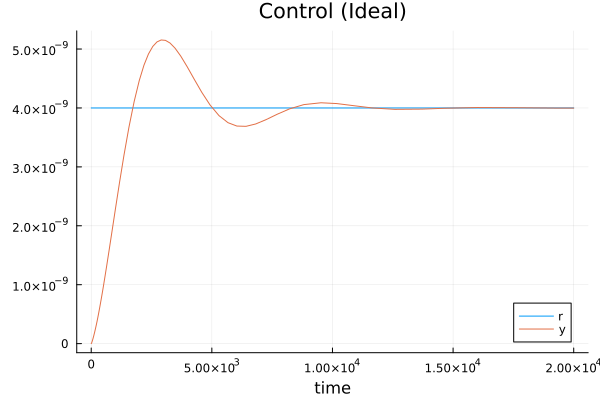

In [25]:
plot()

ki = 1
kp = 1
deg = 8e-4
cat = 8e-4
kicat = ki*cat
kpcat = kp*cat
ann = 1e7
produce = 0.2
consume = 0.1
load = 1e7

rp = 4e-9
rm = 0
xp = 2e-9
xm = 1e-9
vp = 0
vm = 0
ep = 0
em = 0
yp = 0
ym = 0
loadp = 2e-9
loadm = 0



u0 = [
    ep, xp, em, xm, vp, vm, rp, rm, yp, ym, loadp, loadm
]

p = [cat,kicat, kpcat, deg, produce, consume, ann, load]
tspan = (0, 20000)
oprob = ODEProblem(control_ideal_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)
plot(sol, title="Control (Ideal)", legend=:bottomright)
rp = aggregate_values(control_ideal_rn, sol, prefix="rp")
rm = aggregate_values(control_ideal_rn, sol, prefix="rm")
yp = aggregate_values(control_ideal_rn, sol, prefix="yp")
ym = aggregate_values(control_ideal_rn, sol, prefix="ym")

t = sol.t
t = sol.t
plot([t, t], [rp-rm, yp-ym],  xlabel="time", label=["r" "y"], title="Control (Ideal)", legend=:bottomright)

# plot([t, t, t, t], [rp, rm, yp, ym],  xlabel="time", label=["rp" "rm" "yp" "ym"], title="Control (Ideal)", legend=:bottomright)
# plot([t, t, t, t], [rp, rm, yp, ym], label=["rp" "rm" "yp" "ym"])

In [26]:
savefig("images/control_ideal.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/control_ideal.png"

## 3.2 Ideal (From Oishi and Klavins 2011)

In [27]:
# control_ideal_rn = @reaction_network begin
#     ## Plant
#     gd1, 0 --> x5p
#     gd1, 0 --> x5m
#     gd2, x5p --> 0
#     gd2, x5m --> 0
    
#     ## Summation 
#     gamma, up --> up + x1p
#     gamma, um --> um + x1m
#     eta, x1p + x1m --> 0
    
#     ## Weighted integration
#     kI, x1p --> x1p + x4p
#     kI, x1m --> x1m + x4m
#     eta, x4p + x4m --> 0
    
#     ## Weighted summation
#     gkP, x1p --> x1p + x5p
#     gkP, x1m --> x1m + x5m
#     gamma, x4p --> x4p + x5p
#     gamma, x4m --> x4m + x5m
#     eta, x5p + x5m --> 0 
# end gd1 gd2 gamma eta kI gkP

In [28]:
print_species_array(control_ideal_rn)

species = ['ep(t)','xp(t)','em(t)','xm(t)','vp(t)','vm(t)','rp(t)','rm(t)','yp(t)','ym(t)','loadp(t)','loadm(t)',]

## 3.3 Control (Leak = No, Shadow = No)

In [29]:
control_rn = @reaction_network begin
    ## Controller
    # Integration term
    cat/Cmax, ep + gate_G__leaks_Iuniep --> Iuniep
    qmax, Iuniep + gate_G__leaks_ep_xp --> ep + xp
    cat/Cmax, em + gate_G__leaks_Iuniem --> Iuniem
    qmax, Iuniem + gate_G__leaks_em_xm --> em + xm
    
    # Proportional term summation
    kicat/Cmax, xp + gate_G__leaks_Iunixp --> Iunixp
    qmax, Iunixp + gate_G__leaks_xp_vp --> xp + vp
    kicat/Cmax, xm + gate_G__leaks_Iunixm --> Iunixm
    qmax, Iunixm + gate_G__leaks_xm_vm --> xm + vm
    kpcat/Cmax, ep + gate_G__leaks_Iuniep --> Iuniep
    qmax, Iuniep + gate_G__leaks_ep_vp --> ep + vp
    kpcat/Cmax, em + gate_G__leaks_Iuniem --> Iuniem
    qmax, Iuniem + gate_G__leaks_em_vm --> em + vm
    
    deg, vp --> 0
    deg, vm --> 0
    
    # Error difference
    cat/Cmax, rp + gate_G__leaks_Iunirp --> Iunirp
    qmax, Iunirp + gate_G__leaks_rp_ep --> rp + ep
    cat/Cmax, rm + gate_G__leaks_Iunirm --> Iunirm
    qmax, Iunirm + gate_G__leaks_rm_em --> rm + em
    cat/Cmax, yp + gate_G__leaks_Iuniyp --> Iuniyp
    qmax, Iuniyp + gate_G__leaks_yp_em --> yp + em
    cat/Cmax, ym + gate_G__leaks_Iuniym --> Iuniym
    qmax, Iuniym + gate_G__leaks_ym_ep --> ym + ep
    deg, ep --> 0
    deg, em --> 0
    
    ## Plant
    produce, vp --> vp + yp
    produce, vm --> vm + ym
    consume, yp --> 0
    consume, ym --> 0
    load, yp + loadp --> loadp
    load, ym + loadm --> loadm 
    
    ## Annihilations
    ann, xp + xm --> 0
    ann, ep + em --> 0
    ann, yp + ym --> 0
    ann, vp + vm --> 0
    ann, rp + rm --> 0
    ann, loadp + loadm --> 0
    
end cat kicat kpcat deg produce consume ann load Cmax qmax
species(control_rn)

38-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 ep(t)
 gate_G__leaks_Iuniep(t)
 Iuniep(t)
 gate_G__leaks_ep_xp(t)
 xp(t)
 em(t)
 gate_G__leaks_Iuniem(t)
 Iuniem(t)
 gate_G__leaks_em_xm(t)
 xm(t)
 gate_G__leaks_Iunixp(t)
 Iunixp(t)
 gate_G__leaks_xp_vp(t)
 ⋮
 Iunirm(t)
 gate_G__leaks_rm_em(t)
 yp(t)
 gate_G__leaks_Iuniyp(t)
 Iuniyp(t)
 gate_G__leaks_yp_em(t)
 ym(t)
 gate_G__leaks_Iuniym(t)
 Iuniym(t)
 gate_G__leaks_ym_ep(t)
 loadp(t)
 loadm(t)

In [30]:
print_species_array(control_rn)

species = ['ep(t)','gate_G__leaks_Iuniep(t)','Iuniep(t)','gate_G__leaks_ep_xp(t)','xp(t)','em(t)','gate_G__leaks_Iuniem(t)','Iuniem(t)','gate_G__leaks_em_xm(t)','xm(t)','gate_G__leaks_Iunixp(t)','Iunixp(t)','gate_G__leaks_xp_vp(t)','vp(t)','gate_G__leaks_Iunixm(t)','Iunixm(t)','gate_G__leaks_xm_vm(t)','vm(t)','gate_G__leaks_ep_vp(t)','gate_G__leaks_em_vm(t)','rp(t)','gate_G__leaks_Iunirp(t)','Iunirp(t)','gate_G__leaks_rp_ep(t)','rm(t)','gate_G__leaks_Iunirm(t)','Iunirm(t)','gate_G__leaks_rm_em(t)','yp(t)','gate_G__leaks_Iuniyp(t)','Iuniyp(t)','gate_G__leaks_yp_em(t)','ym(t)','gate_G__leaks_Iuniym(t)','Iuniym(t)','gate_G__leaks_ym_ep(t)','loadp(t)','loadm(t)',]

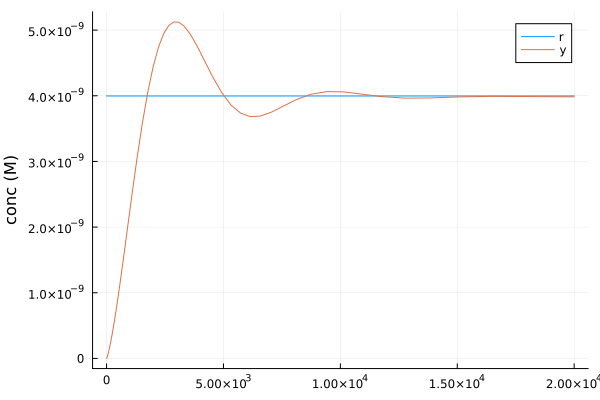

In [33]:
plot()

ki = 1
kp = 1
deg = 8e-4
cat = 8e-4
kicat = ki*cat
kpcat = kp*cat
ann = 1e7
produce = 0.2
consume = 0.1
load = 1e7

rp = 4e-9
rm = 0
xp = 2e-9
xm = 1e-9
vp = 0
vm = 0
ep = 0
em = 0
yp = 0
ym = 0
loadp = 2e-9
loadm = 0

Cmax = 1000e-9
qmax = 1e6
ccmax = cat/Cmax


u0 = [
ep, Cmax, 0.0, Cmax, xp, 
em, Cmax, 0.0, Cmax, xm, 
Cmax, 0.0, Cmax, vp, Cmax, 
0.0, Cmax, vm, Cmax, Cmax, 
rp, Cmax, 0.0, Cmax, rm, 
Cmax, 0.0, Cmax, yp, Cmax, 
0.0, Cmax, ym, Cmax, 0.0, 
Cmax, loadp, loadm, 
]

p = [cat, kicat, kpcat, deg, produce, consume, ann, load, Cmax, qmax]
tspan = (0, 20000)
oprob = ODEProblem(control_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

rp = aggregate_values(control_rn, sol, prefix="rp")
rm = aggregate_values(control_rn, sol, prefix="rm")
vp = aggregate_values(control_rn, sol, prefix="vp")
vm = aggregate_values(control_rn, sol, prefix="vm")
xp = aggregate_values(control_rn, sol, prefix="xp")
xm = aggregate_values(control_rn, sol, prefix="xm")
yp = aggregate_values(control_rn, sol, prefix="yp")
ym = aggregate_values(control_rn, sol, prefix="ym")

t = sol.t
# plot([t, t, t, t, t, t, t, t], [rp, rm, vp, vm, xp, xm, yp, ym], label=["rp" "rm" "vp" "vm" "xp" "xm" "yp" "ym"], legend=:bottomright)
# plot([t, t, t, t], [rp, rm, yp, ym], label=["rp" "rm" "yp" "ym"])
# plot([t, t, t, t], [rp, rm, yp, ym], ylabel="conc (M)", 
#     label=["rp" "rm" "yp" "ym"], legend=:topright)
plot([t, t], [rp-rm, yp-ym], ylabel="conc (M)", 
    label=["r" "y"], legend=:topright)

In [34]:
savefig("images/control_dsd.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/control_dsd.png"

## 3.3 Control (Leak = Yes, Shadow = No)

In [35]:
control_rn = @reaction_network begin
    ## Controller
    # Integration term
    cat/Cmax, ep + gate_G__leaks_Iuniep --> Iuniep
    qmax, Iuniep + gate_G__leaks_ep_xp --> ep + xp
    cat/Cmax, em + gate_G__leaks_Iuniem --> Iuniem
    qmax, Iuniem + gate_G__leaks_em_xm --> em + xm
    
    # Proportional term summation
    kicat/Cmax, xp + gate_G__leaks_Iunixp --> Iunixp
    qmax, Iunixp + gate_G__leaks_xp_vp --> xp + vp
    kicat/Cmax, xm + gate_G__leaks_Iunixm --> Iunixm
    qmax, Iunixm + gate_G__leaks_xm_vm --> xm + vm
    kpcat/Cmax, ep + gate_G__leaks_Iuniep --> Iuniep
    qmax, Iuniep + gate_G__leaks_ep_vp --> ep + vp
    kpcat/Cmax, em + gate_G__leaks_Iuniem --> Iuniem
    qmax, Iuniem + gate_G__leaks_em_vm --> em + vm
    
    deg, vp --> 0
    deg, vm --> 0
    
    # Error difference
    cat/Cmax, rp + gate_G__leaks_Iunirp --> Iunirp
    qmax, Iunirp + gate_G__leaks_rp_ep --> rp + ep
    cat/Cmax, rm + gate_G__leaks_Iunirm --> Iunirm
    qmax, Iunirm + gate_G__leaks_rm_em --> rm + em
    cat/Cmax, yp + gate_G__leaks_Iuniyp --> Iuniyp
    qmax, Iuniyp + gate_G__leaks_yp_em --> yp + em
    cat/Cmax, ym + gate_G__leaks_Iuniym --> Iuniym
    qmax, Iuniym + gate_G__leaks_ym_ep --> ym + ep
    deg, ep --> 0
    deg, em --> 0
    
    ## Plant
    produce, vp --> vp + yp
    produce, vm --> vm + ym
    consume, yp --> 0
    consume, ym --> 0
    load, yp + loadp --> loadp
    load, ym + loadm --> loadm 
    
    ## Annihilations
    ann, xp + xm --> 0
    ann, ep + em --> 0
    ann, yp + ym --> 0
    ann, vp + vm --> 0
    ann, rp + rm --> 0
    ann, loadp + loadm --> 0
    
    ## Leak reactions
    leak*leak_rate, 0 --> xp
    leak*leak_rate, 0 --> vp
    leak*leak_rate, 0 --> yp
#     leak*leak_rate, 0 --> rp
    leak*leak_rate, 0 --> ep
    
end cat kicat kpcat deg produce consume ann load Cmax qmax leak leak_rate
species(control_rn)

38-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 ep(t)
 gate_G__leaks_Iuniep(t)
 Iuniep(t)
 gate_G__leaks_ep_xp(t)
 xp(t)
 em(t)
 gate_G__leaks_Iuniem(t)
 Iuniem(t)
 gate_G__leaks_em_xm(t)
 xm(t)
 gate_G__leaks_Iunixp(t)
 Iunixp(t)
 gate_G__leaks_xp_vp(t)
 ⋮
 Iunirm(t)
 gate_G__leaks_rm_em(t)
 yp(t)
 gate_G__leaks_Iuniyp(t)
 Iuniyp(t)
 gate_G__leaks_yp_em(t)
 ym(t)
 gate_G__leaks_Iuniym(t)
 Iuniym(t)
 gate_G__leaks_ym_ep(t)
 loadp(t)
 loadm(t)

In [36]:
print_species_array(control_rn)

species = ['ep(t)','gate_G__leaks_Iuniep(t)','Iuniep(t)','gate_G__leaks_ep_xp(t)','xp(t)','em(t)','gate_G__leaks_Iuniem(t)','Iuniem(t)','gate_G__leaks_em_xm(t)','xm(t)','gate_G__leaks_Iunixp(t)','Iunixp(t)','gate_G__leaks_xp_vp(t)','vp(t)','gate_G__leaks_Iunixm(t)','Iunixm(t)','gate_G__leaks_xm_vm(t)','vm(t)','gate_G__leaks_ep_vp(t)','gate_G__leaks_em_vm(t)','rp(t)','gate_G__leaks_Iunirp(t)','Iunirp(t)','gate_G__leaks_rp_ep(t)','rm(t)','gate_G__leaks_Iunirm(t)','Iunirm(t)','gate_G__leaks_rm_em(t)','yp(t)','gate_G__leaks_Iuniyp(t)','Iuniyp(t)','gate_G__leaks_yp_em(t)','ym(t)','gate_G__leaks_Iuniym(t)','Iuniym(t)','gate_G__leaks_ym_ep(t)','loadp(t)','loadm(t)',]

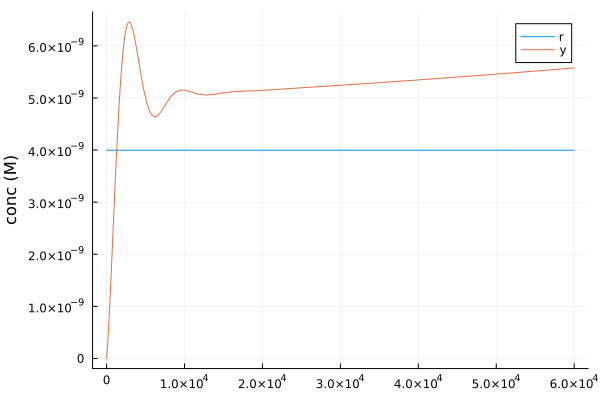

In [37]:
plot()

ki = 1
kp = 1
deg = 8e-4
cat = 8e-4
kicat = ki*cat
kpcat = kp*cat
ann = 1e7
produce = 0.2
consume = 0.1
load = 1e7

rp = 4e-9
rm = 0
xp = 2e-9
xm = 1e-9
vp = 0
vm = 0
ep = 0
em = 0
yp = 0
ym = 0
loadp = 2e-9
loadm = 0

Cmax = 1000e-9
qmax = 1e6
leak = 1
leak_rate = 4e-13

u0 = [
ep, Cmax, 0.0, Cmax, xp, 
em, Cmax, 0.0, Cmax, xm, 
Cmax, 0.0, Cmax, vp, Cmax, 
0.0, Cmax, vm, Cmax, Cmax, 
rp, Cmax, 0.0, Cmax, rm, 
Cmax, 0.0, Cmax, yp, Cmax, 
0.0, Cmax, ym, Cmax, 0.0, 
Cmax, loadp, loadm, 
]

p = [cat, kicat, kpcat, deg, produce, consume, ann, load, Cmax, qmax, leak, leak_rate]
tspan = (0, 60000)
oprob = ODEProblem(control_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

rp = aggregate_values(control_rn, sol, prefix="rp")
rm = aggregate_values(control_rn, sol, prefix="rm")
vp = aggregate_values(control_rn, sol, prefix="vp")
vm = aggregate_values(control_rn, sol, prefix="vm")
xp = aggregate_values(control_rn, sol, prefix="xp")
xm = aggregate_values(control_rn, sol, prefix="xm")
yp = aggregate_values(control_rn, sol, prefix="yp")
ym = aggregate_values(control_rn, sol, prefix="ym")

t = sol.t
plot([t, t, t, t, t, t, t, t], [rp, rm, vp, vm, xp, xm, yp, ym], label=["rp" "rm" "vp" "vm" "xp" "xm" "yp" "ym"], legend=:bottomright)
# plot([t, t, t, t], [rp, rm, yp, ym], label=["rp" "rm" "yp" "ym"])
# plot([t, t, t, t], [rp, rm, yp, ym], ylabel="conc (M)", 
#     label=["rp" "rm" "yp" "ym"], legend=:topright)
plot([t, t], [rp-rm, yp-ym], ylabel="conc (M)", 
    label=["r" "y"], legend=:topright)

In [38]:
savefig("images/control_leaky.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/control_leaky.png"

## 3.4 Control (Leak = Yes, Shadow = Yes)

In [43]:
control_rn = @reaction_network begin
    ## Controller
    # Integration term
    cat/Cmax, ep + gate_G__leaks_Iuniep --> Iuniep
    qmax, Iuniep + gate_G__leaks_ep_xp --> ep + xp
    cat/Cmax, em + gate_G__leaks_Iuniem --> Iuniem
    qmax, Iuniem + gate_G__leaks_em_xm --> em + xm
    # -- 
    shadow*cat/Cmax, shadow_ep + gate_G__leaks_Iuniep --> shadow_Iuniep
    shadow*qmax, shadow_Iuniep + shadow_gate_G__leaks_ep_xp --> shadow_ep + shadow_xp
    shadow*cat/Cmax, shadow_em + shadow_gate_G__leaks_Iuniem --> shadow_Iuniem
    shadow*qmax, shadow_Iuniem + shadow_gate_G__leaks_em_xm --> shadow_em + shadow_xm
    
    # Proportional term summation
    kicat/Cmax, xp + gate_G__leaks_Iunixp --> Iunixp
    qmax, Iunixp + gate_G__leaks_xp_vp --> xp + vp
    kicat/Cmax, xm + gate_G__leaks_Iunixm --> Iunixm
    qmax, Iunixm + gate_G__leaks_xm_vm --> xm + vm
    kpcat/Cmax, ep + gate_G__leaks_Iuniep --> Iuniep
    qmax, Iuniep + gate_G__leaks_ep_vp --> ep + vp
    kpcat/Cmax, em + gate_G__leaks_Iuniem --> Iuniem
    qmax, Iuniem + gate_G__leaks_em_vm --> em + vm
    deg, vp --> 0
    deg, vm --> 0
    
    # -- 
    
    shadow*kicat/Cmax, shadow_xp + shadow_gate_G__leaks_Iunixp --> shadow_Iunixp
    shadow*qmax, shadow_Iunixp + shadow_gate_G__leaks_xp_vp --> shadow_xp + shadow_vp
    shadow*kicat/Cmax, shadow_xm + shadow_gate_G__leaks_Iunixm --> shadow_Iunixm
    shadow*qmax, shadow_Iunixm + shadow_gate_G__leaks_xm_vm --> shadow_xm + shadow_vm
    shadow*kpcat/Cmax, shadow_ep + shadow_gate_G__leaks_Iuniep --> shadow_Iuniep
    shadow*qmax, shadow_Iuniep + shadow_gate_G__leaks_ep_vp --> shadow_ep + shadow_vp
    shadow*kpcat/Cmax, shadow_em + shadow_gate_G__leaks_Iuniem --> shadow_Iuniem
    shadow*qmax, shadow_Iuniem + shadow_gate_G__leaks_em_vm --> shadow_em + shadow_vm
    shadow*deg, shadow_vp --> 0
    shadow*deg, shadow_vm --> 0
    
    # Error difference
    cat/Cmax, rp + gate_G__leaks_Iunirp --> Iunirp
    qmax, Iunirp + gate_G__leaks_rp_ep --> rp + ep
    cat/Cmax, rm + gate_G__leaks_Iunirm --> Iunirm
    qmax, Iunirm + gate_G__leaks_rm_em --> rm + em
    cat/Cmax, yp + gate_G__leaks_Iuniyp --> Iuniyp
    qmax, Iuniyp + gate_G__leaks_yp_em --> yp + em
    cat/Cmax, ym + gate_G__leaks_Iuniym --> Iuniym
    qmax, Iuniym + gate_G__leaks_ym_ep --> ym + ep
    deg, ep --> 0
    deg, em --> 0
    # -- 
    shadow*cat/Cmax, shadow_rp + shadow_gate_G__leaks_Iunirp --> shadow_Iunirp
    shadow*qmax, shadow_Iunirp + shadow_gate_G__leaks_rp_ep --> shadow_rp + shadow_ep
    shadow*cat/Cmax, shadow_rm + shadow_gate_G__leaks_Iunirm --> shadow_Iunirm
    shadow*qmax, shadow_Iunirm + shadow_gate_G__leaks_rm_em --> shadow_rm + shadow_em
    shadow*cat/Cmax, shadow_yp + shadow_gate_G__leaks_Iuniyp --> shadow_Iuniyp
    shadow*qmax, shadow_Iuniyp + shadow_gate_G__leaks_yp_em --> shadow_yp + shadow_em
    shadow*cat/Cmax, shadow_ym + shadow_gate_G__leaks_Iuniym --> shadow_Iuniym
    shadow*qmax, shadow_Iuniym + shadow_gate_G__leaks_ym_ep --> shadow_ym + shadow_ep
    shadow*deg, shadow_ep --> 0
    shadow*deg, shadow_em --> 0
    
    ## Plant
    produce, vp --> vp + yp
    produce, vm --> vm + ym
    consume, yp --> 0
    consume, ym --> 0
    load, yp + loadp --> loadp
    load, ym + loadm --> loadm
    # -- 
    shadow*produce, shadow_vp --> shadow_vp + shadow_yp
    shadow*produce, shadow_vm --> shadow_vm + shadow_ym
    shadow*consume, shadow_yp --> 0
    shadow*consume, shadow_ym --> 0
    shadow*load, shadow_yp + shadow_loadp --> shadow_loadp
    shadow*load, shadow_ym + shadow_loadm --> shadow_loadm
    
    ## Annihilations
    ann, xp + xm --> 0
    ann, ep + em --> 0
    ann, yp + ym --> 0
    ann, vp + vm --> 0
    ann, rp + rm --> 0
    ann, loadp + loadm --> 0
    # --
    shadow*ann, shadow_xp + shadow_xm --> 0
    shadow*ann, shadow_ep + shadow_em --> 0
    shadow*ann, shadow_yp + shadow_ym --> 0
    shadow*ann, shadow_vp + shadow_vm --> 0
    shadow*ann, shadow_rp + shadow_rm --> 0
    shadow*ann, shadow_loadp + shadow_loadm --> 0
    
    ## Leak reactions
    leak*leak_rate, 0 --> xp
    leak*leak_rate, 0 --> vp
    leak*leak_rate, 0 --> yp
    leak*leak_rate, 0 --> rp
    leak*leak_rate, 0 --> ep
    # -- 
    shadow*leak*leak_rate, 0 --> shadow_xp
    shadow*leak*leak_rate, 0 --> shadow_vp
    shadow*leak*leak_rate, 0 --> shadow_yp
    shadow*leak*leak_rate, 0 --> shadow_rp
    shadow*leak*leak_rate, 0 --> shadow_ep
    
    ## Leak cancellation reactions
    shadow*leak*ann, xp + shadow_xp --> 0
    shadow*leak*ann, xm + shadow_xm --> 0
    shadow*leak*ann, vp + shadow_vp --> 0
    shadow*leak*ann, vm + shadow_vm --> 0
    shadow*leak*ann, yp + shadow_yp --> 0
    shadow*leak*ann, ym + shadow_ym --> 0
    shadow*leak*ann, rp + shadow_rp --> 0
    shadow*leak*ann, rm + shadow_rm --> 0
    shadow*leak*ann, ep + shadow_ep --> 0
    shadow*leak*ann, em + shadow_em --> 0
    shadow*leak*ann, loadp + shadow_loadp --> 0
    shadow*leak*ann, loadm + shadow_loadm --> 0
    
end cat kicat kpcat deg produce consume ann load Cmax qmax leak leak_rate shadow
species(control_rn)

76-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 ep(t)
 gate_G__leaks_Iuniep(t)
 Iuniep(t)
 gate_G__leaks_ep_xp(t)
 xp(t)
 em(t)
 gate_G__leaks_Iuniem(t)
 Iuniem(t)
 gate_G__leaks_em_xm(t)
 xm(t)
 shadow_ep(t)
 shadow_Iuniep(t)
 shadow_gate_G__leaks_ep_xp(t)
 ⋮
 shadow_yp(t)
 shadow_gate_G__leaks_Iuniyp(t)
 shadow_Iuniyp(t)
 shadow_gate_G__leaks_yp_em(t)
 shadow_ym(t)
 shadow_gate_G__leaks_Iuniym(t)
 shadow_Iuniym(t)
 shadow_gate_G__leaks_ym_ep(t)
 loadp(t)
 loadm(t)
 shadow_loadp(t)
 shadow_loadm(t)

In [44]:
print_species_array(control_rn)

species = ['ep(t)','gate_G__leaks_Iuniep(t)','Iuniep(t)','gate_G__leaks_ep_xp(t)','xp(t)','em(t)','gate_G__leaks_Iuniem(t)','Iuniem(t)','gate_G__leaks_em_xm(t)','xm(t)','shadow_ep(t)','shadow_Iuniep(t)','shadow_gate_G__leaks_ep_xp(t)','shadow_xp(t)','shadow_em(t)','shadow_gate_G__leaks_Iuniem(t)','shadow_Iuniem(t)','shadow_gate_G__leaks_em_xm(t)','shadow_xm(t)','gate_G__leaks_Iunixp(t)','Iunixp(t)','gate_G__leaks_xp_vp(t)','vp(t)','gate_G__leaks_Iunixm(t)','Iunixm(t)','gate_G__leaks_xm_vm(t)','vm(t)','gate_G__leaks_ep_vp(t)','gate_G__leaks_em_vm(t)','shadow_gate_G__leaks_Iunixp(t)','shadow_Iunixp(t)','shadow_gate_G__leaks_xp_vp(t)','shadow_vp(t)','shadow_gate_G__leaks_Iunixm(t)','shadow_Iunixm(t)','shadow_gate_G__leaks_xm_vm(t)','shadow_vm(t)','shadow_gate_G__leaks_Iuniep(t)','shadow_gate_G__leaks_ep_vp(t)','shadow_gate_G__leaks_em_vm(t)','rp(t)','gate_G__leaks_Iunirp(t)','Iunirp(t)','gate_G__leaks_rp_ep(t)','rm(t)','gate_G__leaks_Iunirm(t)','Iunirm(t)','gate_G__leaks_rm_em(t)','yp(t)'

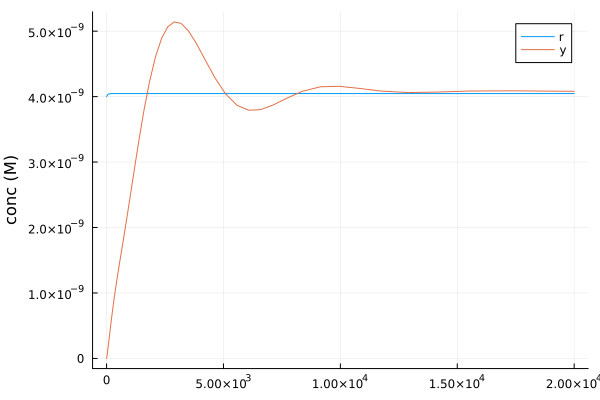

In [53]:
plot()

ki = 1
kp = 1
deg = 8e-4
cat = 8e-4
kicat = ki*cat
kpcat = kp*cat
ann = 5e6
produce = 0.2
consume = 0.1
load = 1e7

rp = 4e-9
rm = 0
xp = 2e-9
xm = 1e-9
vp = 0
vm = 0
ep = 0
em = 0
yp = 0
ym = 0
loadp = 2e-9
loadm = 0

Cmax = 1000e-9
qmax = 1e6
leak = 1
leak_rate = 1e-12
shadow = 1


u0 = [
ep, Cmax, 0.0, Cmax, xp, 
em, Cmax, 0.0, Cmax, xm, 
0.0, 0.0, Cmax, 0.0, 0.0, 
Cmax, 0.0, Cmax, 0.0, Cmax, 
0.0, Cmax, vp, Cmax, 0.0, 
Cmax, vm, Cmax, Cmax, Cmax, 
0.0, Cmax, 0.0, Cmax, 0.0, 
Cmax, 0.0, Cmax, Cmax, Cmax, 
rp, Cmax, 0.0, Cmax, rm, 
Cmax, 0.0, Cmax, yp, Cmax, 
0.0, Cmax, ym, Cmax, 0.0, 
Cmax, 0.0, Cmax, 0.0, Cmax, 
0.0, Cmax, 0.0, Cmax, 0.0, 
Cmax, 0.0, Cmax, 0.0, Cmax, 
0.0, Cmax, loadp, loadm, 0.0, 
0.0, 
]

p = [cat, kicat, kpcat, deg, produce, consume, ann, load, Cmax, qmax, leak, leak_rate, shadow]
tspan = (0, 20000)
oprob = ODEProblem(control_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

rp = aggregate_values(control_rn, sol, prefix="rp")
rm = aggregate_values(control_rn, sol, prefix="rm")
vp = aggregate_values(control_rn, sol, prefix="vp")
vm = aggregate_values(control_rn, sol, prefix="vm")
xp = aggregate_values(control_rn, sol, prefix="xp")
xm = aggregate_values(control_rn, sol, prefix="xm")
yp = aggregate_values(control_rn, sol, prefix="yp")
ym = aggregate_values(control_rn, sol, prefix="ym")

t = sol.t
plot([t, t, t, t, t, t, t, t], [rp, rm, vp, vm, xp, xm, yp, ym], label=["rp" "rm" "vp" "vm" "xp" "xm" "yp" "ym"], legend=:bottomright)
# plot([t, t, t, t], [rp, rm, yp, ym], label=["rp" "rm" "yp" "ym"])
# plot([t, t, t, t], [rp, rm, yp, ym], ylabel="conc (M)", 
#     label=["rp" "rm" "yp" "ym"], legend=:topright)
plot([t, t], [rp-rm, yp-ym], ylabel="conc (M)", 
    label=["r" "y"], legend=:topright)

In [54]:
savefig("images/control_leaky_shadow.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/control_leaky_shadow.png"

# Lotka-Volterra oscillator

## Ideal 

In [55]:
lvo_alt_ideal_rn = @reaction_network begin
    1.5, x1 + x2 --> x2 + x2
    1, x1 --> x1 + x1
    1, x2 --> 0
end
species(lvo_alt_ideal_rn)

2-element Vector{Term{Real, Base.ImmutableDict{DataType, Any}}}:
 x1(t)
 x2(t)

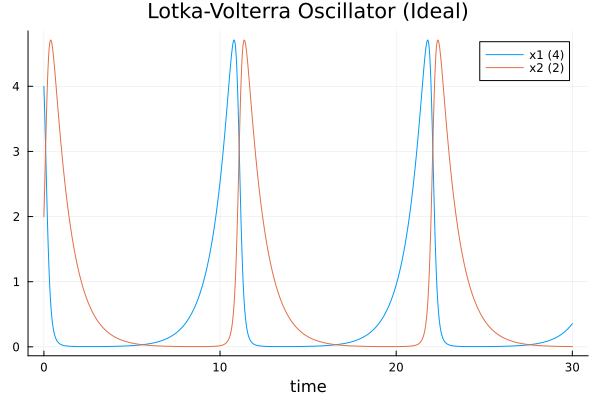

In [56]:
tspan = (0, 30)
x1init = 4
x2init = 2

u0 = [x1init, x2init]
p = []
oprob = ODEProblem(lvo_alt_ideal_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

t = sol.t
x1plot = aggregate_values(lvo_alt_ideal_rn, sol, prefix="x1")
x2plot = aggregate_values(lvo_alt_ideal_rn, sol, prefix="x2")
t1 = sol.t
# p1 = plot([t1, t1], [x1plot, x2plot], labels=["x1 (4)" "x2 (2)"])
# p2 = plot(x1plot, x2plot, xlabel=:x1, ylabel=:x2)
# plot(p1, p2, layout=(1, 2), size=(1000, 500), title="Lotka-Volterra Oscillator (Ideal)", legend=:bottomright)
p1 = plot([t1, t1], [x1plot, x2plot],  xlabel="time", labels=["x1 (4)" "x2 (2)"], title="Lotka-Volterra Oscillator (Ideal)", legend=:topright)


In [57]:
savefig("images/lvo_alt_ideal.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/lvo_alt_ideal.png"

## LV Oscillator (DSD)

In [58]:
lvo_alt_dsd_rn = @reaction_network begin
    # x1 + x2 --> 2x2
    q1, x1 + L1 --> H1 + B1
    qmax, B1 + H1 --> x1 + L1
    qmax, x2 + H1 --> o1
    qmax, o1 + T1 --> x2 + x2
    qs2, x2 + LS2 --> HS2 + BS2
    qmax, BS2 + HS2 --> x2 + LS2
    # x1 --> 2x1
    q2, x1 + G2 --> o2
    qmax, o2 + T2 --> x1 + x1
    # x2 --> 0
    q3, x2 + G3 --> o3
    qmax, o3 + T3 --> 0
    
end q1 q2 q3 qmax qs2 
species(lvo_alt_dsd_rn), length(species(lvo_alt_dsd_rn))

(Term{Real, Base.ImmutableDict{DataType, Any}}[x1(t), L1(t), H1(t), B1(t), x2(t), o1(t), T1(t), LS2(t), HS2(t), BS2(t), G2(t), o2(t), T2(t), G3(t), o3(t), T3(t)], 16)

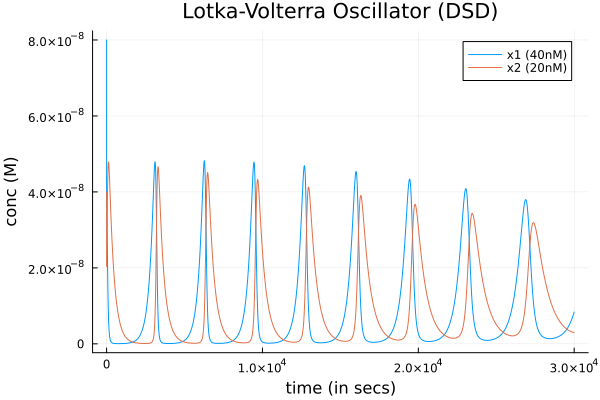

In [59]:
plot()
gamma_inv = 2
x1init = gamma_inv*40e-9 # 40 nM
x2init = gamma_inv*20e-9 # 20 nM
Cmax = 2000e-9 # 10uM
k1 = 5e5
k2 = 1/300
k3 = 1/300
q1 = gamma_inv*k1
q2 = gamma_inv*k2/Cmax
q3 = gamma_inv*k3/Cmax
qs2 = gamma_inv*k1
qmax = 1e6

u0 = [x1init, Cmax, 0, Cmax, x2init, 0, Cmax, Cmax, 0, Cmax, Cmax, 0, Cmax, Cmax, 0, Cmax]
p = [q1, q2, q3, qmax, qs2]
tspan = (0, 30000)
oprob = ODEProblem(lvo_alt_dsd_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

x1plot = aggregate_values(lvo_alt_dsd_rn, sol, prefix="x1")
x2plot = aggregate_values(lvo_alt_dsd_rn, sol, prefix="x2")
t1 = sol.t
p1 = plot([t1, t1], [x1plot, x2plot],  xlabel="time (in secs)", ylabel="conc (M)", labels=["x1 (40nM)" "x2 (20nM)"], title="Lotka-Volterra Oscillator (DSD)", legend=:topright)

In [60]:
savefig("images/lvo_alt_dsd.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/lvo_alt_dsd.png"

## LV Oscillator (Leaks = Yes | Shadow = No)

In [75]:
lvo_alt_rn = @reaction_network begin
    # x1 + x2 --> 2x2
    q1, x1 + L1 --> H1 + B1 # no need for B1 leak as it is already present
    qmax, B1 + H1 --> x1 + L1

    qmax, x2 + H1 --> o1
    qmax, o1 + T1 --> x2 + x2
    qs2, x2 + LS2 --> HS2 + BS2 # No need to leak BS2 as it is already present
    qmax, BS2 + HS2 --> x2 + LS2
    # x1 --> 2x1
    q2, x1 + G2 --> o2
    qmax, o2 + T2 --> x1 + x1
    # x2 --> 0
    q3, x2 + G3 --> o3
    qmax, o3 + T3 --> 0
    
    # Leak reactions
    leak*leak_rate, 0 --> x2 + x2
    leak*leak_rate, 0 --> x1 + x1
    
    
end q1 q2 q3 qmax qs2 leak leak_rate
species(lvo_alt_rn), length(species(lvo_alt_rn))

(Term{Real, Base.ImmutableDict{DataType, Any}}[x1(t), L1(t), H1(t), B1(t), x2(t), o1(t), T1(t), LS2(t), HS2(t), BS2(t), G2(t), o2(t), T2(t), G3(t), o3(t), T3(t)], 16)

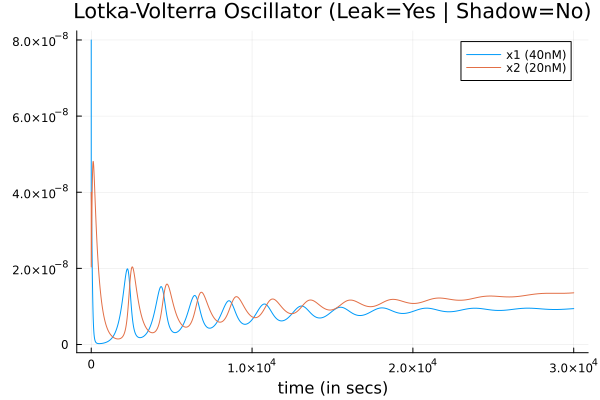

In [76]:
plot()
gamma_inv = 2
x1init = gamma_inv*40e-9 # 20nM
x2init = gamma_inv*20e-9 # 10nM
Cmax = 2000e-9 # 10uM
k1 = 5e5
k2 = 1/300
k3 = 1/300
q1 = gamma_inv*k1
q2 = gamma_inv*k2/Cmax
q3 = gamma_inv*k3/Cmax
qs2 = gamma_inv*k1
qmax = 1e6
leak = 1
leak_rate = 1e-12

u0 = [x1init, Cmax, 0, Cmax, x2init, 0, Cmax, Cmax, 0, Cmax, Cmax, 0, Cmax, Cmax, 0, Cmax]
p = [q1, q2, q3, qmax, qs2, leak, leak_rate]
tspan = (0, 30000)
oprob = ODEProblem(lvo_alt_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

x1plot = aggregate_values(lvo_alt_rn, sol, prefix="x1")
x2plot = aggregate_values(lvo_alt_rn, sol, prefix="x2")
t1 = sol.t
p1 = plot([t1, t1], [x1plot, x2plot],  xlabel="time (in secs)", labels=["x1 (40nM)" "x2 (20nM)"], title="Lotka-Volterra Oscillator (Leak=Yes | Shadow=No)", legend=:topright)
# p2 = plot(x1plot, x2plot, xlabel=:x1, ylabel=:x2, legend=:none)
# plot(p1, layout=(1, 2), size=(1000, 500), title="Lotka-Volterra Oscillator (Leak=Yes | Shadow=No)", legend=:bottomright)

In [71]:
savefig("images/lvo_alt_leaky.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/lvo_alt_leaky.png"

## LV Oscillator (Leaks=Yes | Shadow=Yes)

In [72]:
lvo_alt_rn = @reaction_network begin
    # x1 + x2 --> 2x2
    q1, x1 + L1 --> H1 + B1 # no need for B1 leak as it is already present
    shadow*q1, sx1 + sL1 --> sH1 + sB1 # no need for B1 leak as it is already present
    qmax, B1 + H1 --> x1 + L1
    shadow*qmax, sB1 + sH1 --> sx1 + sL1
    qmax, x2 + H1 --> o1
    shadow*qmax, sx2 + sH1 --> so1
    qmax, o1 + T1 --> x2 + x2
    shadow*qmax, so1 + sT1 --> sx2 + sx2
    qs2, x2 + LS2 --> HS2 + BS2 # No need to leak BS2 as it is already present
    shadow*qs2, sx2 + sLS2 --> sHS2 + sBS2 # No need to leak BS2 as it is already present
    qmax, BS2 + HS2 --> x2 + LS2
    shadow*qmax, sBS2 + sHS2 --> sx2 + sLS2
    # x1 --> 2x1
    q2, x1 + G2 --> o2
    shadow*q2, sx1 + sG2 --> so2
    
    qmax, o2 + T2 --> x1 + x1
    shadow*qmax, so2 + sT2 --> sx1 + sx1
    # x2 --> 0
    q3, x2 + G3 --> o3
    shadow*q3, sx2 + sG3 --> so3
    qmax, o3 + T3 --> 0
    shadow*qmax, so3 + sT3 --> 0
    
    # Leak reactions
    leak*leak_rate, 0 --> x2 + x2
    leak*leak_rate, 0 --> x1 + x1
    
    # Shadow Leak reactions
    shadow*leak*leak_rate, 0 --> sx2 + sx2
    shadow*leak*leak_rate, 0 --> sx1 + sx1
    
    
    # Shadow cancellation
    shadow*leak*annih, x1 + sx1 --> 0
    shadow*leak*annih, x2 + sx2 --> 0
    
end q1 q2 q3 qmax qs2 leak leak_rate shadow annih
sps = print_species_array(lvo_alt_rn)

species = ['x1(t)','L1(t)','H1(t)','B1(t)','sx1(t)','sL1(t)','sH1(t)','sB1(t)','x2(t)','o1(t)','sx2(t)','so1(t)','T1(t)','sT1(t)','LS2(t)','HS2(t)','BS2(t)','sLS2(t)','sHS2(t)','sBS2(t)','G2(t)','o2(t)','sG2(t)','so2(t)','T2(t)','sT2(t)','G3(t)','o3(t)','sG3(t)','so3(t)','T3(t)','sT3(t)',]

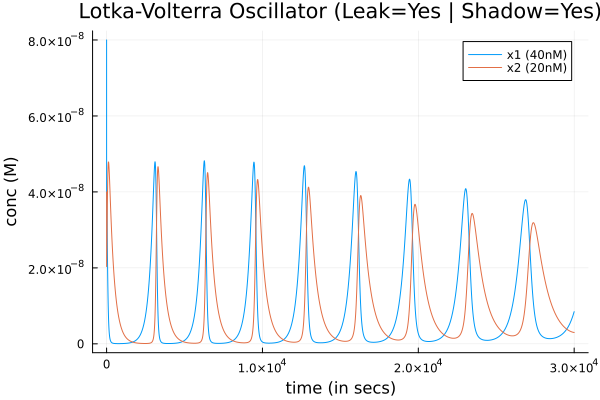

In [74]:
plot()
gamma_inv = 2
x1init = gamma_inv*40e-9 # 20nM
x2init = gamma_inv*20e-9 # 10nM
Cmax = 2000e-9 # 10uM
k1 = 5e5
k2 = 1/300
k3 = 1/300
q1 = gamma_inv*k1
q2 = gamma_inv*k2/Cmax
q3 = gamma_inv*k3/Cmax
qs2 = gamma_inv*k1
qmax = 1e6
leak = 0
leak_rate = 1e-12
shadow = 0
annih = 1e5 # TODO (How to set annihilation reactions!)

u0 = [x1init, Cmax, 0, Cmax, 0, Cmax, 
      0, Cmax, x2init, 0, 0, 0, 
      Cmax, Cmax, Cmax, 0, Cmax, Cmax, 
      0, Cmax, Cmax, 0, Cmax, 0, 
      Cmax, Cmax, Cmax, 0, Cmax, 0, Cmax, Cmax]

p = [q1, q2, q3, qmax, qs2, leak, leak_rate, shadow, annih]
tspan = (0,30000)
oprob = ODEProblem(lvo_alt_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

x1plot = aggregate_values(lvo_alt_rn, sol, prefix="x1")
x2plot = aggregate_values(lvo_alt_rn, sol, prefix="x2")
t1 = sol.t

# p1 = plot([t1, t1], [x1plot, x2plot], labels=["x1 (40nM)" "x2 (20nM)"])
# p2 = plot(x1plot, x2plot, xlabel=:x1, ylabel=:x2)
# plot(p1, p2, layout=(1, 2), size=(1000, 500), title="Lotka-Volterra Oscillator (DSD)", legend=:bottomright)
p1 = plot([t1, t1], [x1plot, x2plot],  xlabel="time (in secs)", ylabel="conc (M)", labels=["x1 (40nM)" "x2 (20nM)"], title="Lotka-Volterra Oscillator (Leak=Yes | Shadow=Yes)", legend=:topright)

In [66]:
savefig("images/lvo_alt_leaky_shadow.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/lvo_alt_leaky_shadow.png"

# Bimolecular Autocatalytic Reaction

## Ideal

In [6]:
bimol_ideal_rn = @reaction_network begin
    1, x + y --> y + y
end

Model ##ReactionSystem#312
States (2):
  x(t)
  y(t)
Parameters (0):

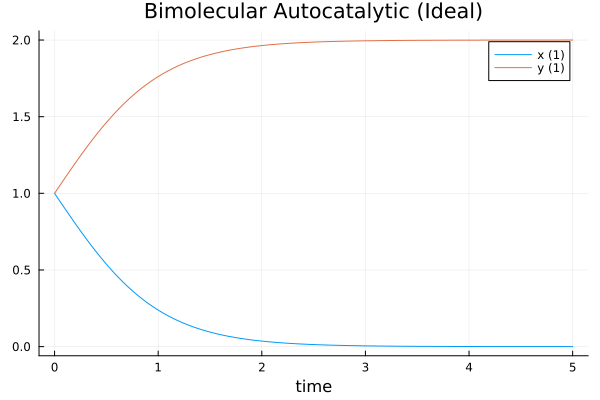

In [7]:
tspan = (0, 5)
xinit = 1
yinit = 1

u0 = [xinit, yinit]
p = []
oprob = ODEProblem(bimol_ideal_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

xplot = aggregate_values(bimol_ideal_rn, sol, prefix="x")
yplot = aggregate_values(bimol_ideal_rn, sol, prefix="y")
t = sol.t
p1 = plot([t, t], [xplot, yplot],  xlabel="time", labels=["x (1)" "y (1)"], title="Bimolecular Autocatalytic (Ideal)", legend=:topright)


## Bimolecular Autocatalytic DSD (Leaks=0, Shadow=0)

In [8]:
bimol_rn = @reaction_network begin
    q, x + gate_L_x_y --> buffer_H_x_y_leaks_x + BSbixy
    qmax, BSbixy + buffer_H_x_y_leaks_x --> x + gate_L_x_y
    qmax, y + buffer_H_x_y_leaks_x --> Ibixy
    qmax, Ibixy + gate_T_x_y_leaks_y_y --> y + y
end q qmax 
print_species_array(bimol_rn)

species = ['x(t)','gate_L_x_y(t)','buffer_H_x_y_leaks_x(t)','BSbixy(t)','y(t)','Ibixy(t)','gate_T_x_y_leaks_y_y(t)',]

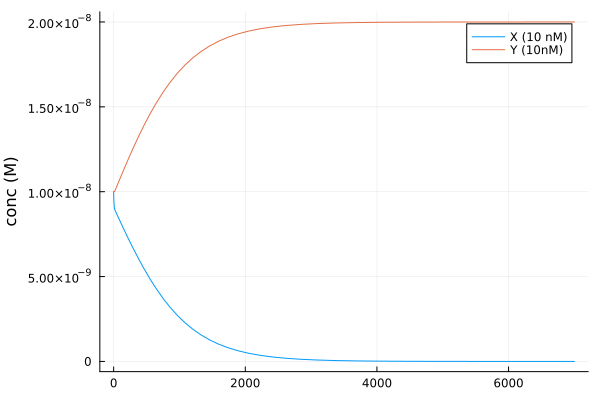

In [9]:
qmax = 1e6 # /M sec
k = 1e5 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

xinit = 10*1e-9
yinit = 10*1e-9

Cmax = 200e-9 # 200nM

u0 = [
xinit, Cmax, 0.0, Cmax, yinit, 
0.0, Cmax, 
]
p = [q, qmax]

tspan = (0, 7000)
oprob = ODEProblem(bimol_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

xplot = aggregate_values(bimol_rn, sol, prefix="x")
yplot = aggregate_values(bimol_rn, sol, prefix="y")
t = sol.t
plot([t, t], [xplot, yplot], ylabel="conc (M)", 
    labels=["X (10 nM)" "Y (10nM)"], legend=:topright)

In [10]:
bimol_rn = @reaction_network begin
    q, x + gate_L_x_y --> buffer_H_x_y_leaks_x + BSbixy
    qmax, BSbixy + buffer_H_x_y_leaks_x --> x + gate_L_x_y
    
    qmax, y + buffer_H_x_y_leaks_x --> Ibixy
    qmax, Ibixy + gate_T_x_y_leaks_y_y --> y + y
    
    leak*leak_rate, 0 --> x 
    2*leak*leak_rate, 0 --> y
end q qmax leak leak_rate
print_species_array(bimol_rn)

species = ['x(t)','gate_L_x_y(t)','buffer_H_x_y_leaks_x(t)','BSbixy(t)','y(t)','Ibixy(t)','gate_T_x_y_leaks_y_y(t)',]

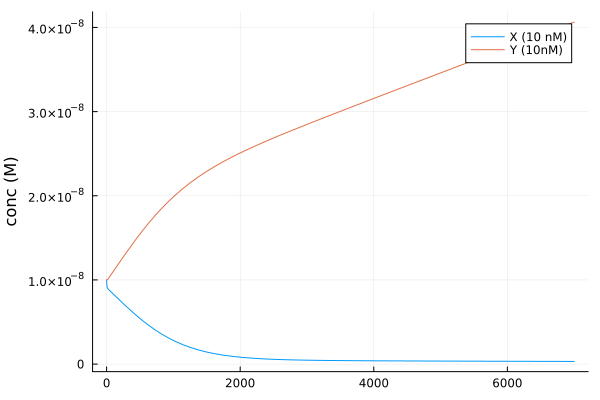

In [11]:
qmax = 1e6 # /M sec
k = 1e5 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

xinit = 10*1e-9
yinit = 10*1e-9

Cmax = 200e-9 # 200nM

leak = 1
leak_rate = 1e-12


u0 = [
xinit, Cmax, 0.0, Cmax, yinit, 
0.0, Cmax, 
]

p = [q, qmax, leak, leak_rate]

tspan = (0, 7000)
oprob = ODEProblem(bimol_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

xplot = aggregate_values(bimol_rn, sol, prefix="x")
yplot = aggregate_values(bimol_rn, sol, prefix="y")
t = sol.t
plot([t, t], [xplot, yplot], ylabel="conc (M)", 
    labels=["X (10 nM)" "Y (10nM)"], legend=:topright)

## Bimolecular Autocatalytic DSD (Leaks=1, Shadow=1)

In [12]:
bimol_rn = @reaction_network begin
#=
    CRN:
    ----
    original: 
    x + y --> y + y
    shadow: 
    x + shadow_y --> shadow_y + shadow_y
    ----
    : Buffering the first reactant
    : Here, q <= qmax i.e., buffering rate is smaller than the maximum strand displ rate.
    : First element is shared between original and shadow circuits. This is an adhoc change made
      to make the designs in Srinivas et al. 2017 to work as shadow circuit.
    : Second order annihilation rate constant `ann = 0.1 nM^-1 s^-1' 
    : Leak rate of `y' (Zeroth order): `leak_rate = 0.36 nM/hr = 1e-13 M/s'
    : Leak rate of `x' (First order dissociative pathway) = 1e-5 s^-1'
    : The overall DSD circuit design follows Soloveichik et al., here. 
=#
    # Buffering the first reactant `x' in original and shadow circuits
    q, x + gate_L_x_y --> buffer_H_x_y_leaks_x + BSbixy # original
    qmax, BSbixy + buffer_H_x_y_leaks_x --> x + gate_L_x_y # original
    
    shadow*q, x + shadow_gate_L_x_y --> shadow_buffer_H_x_y_leaks_x + shadow_BSbixy # shadow
    shadow*qmax, shadow_BSbixy + shadow_buffer_H_x_y_leaks_x --> x + shadow_gate_L_x_y # shadow
    
    # `y' reacting with `x' in its buffer form in two steps
    qmax, y + buffer_H_x_y_leaks_x --> Ibixy # original
    qmax, Ibixy + gate_T_x_y_leaks_y_y --> y + y # original
    
    shadow*qmax, shadow_y + shadow_buffer_H_x_y_leaks_x --> shadow_Ibixy # shadow
    shadow*qmax, shadow_Ibixy + shadow_gate_T_x_y_leaks_y_y --> shadow_y + shadow_y # shadow
    
     # Leak reactions
    leak*leak_rate, 0 --> y # Leak rate from Srinivas et al. 2017
    leak*1e-5, buffer_H_x_y_leaks_x --> x # Dissociative pathway from Reynaldo et al. 2000
    leak*1e-5, shadow_buffer_H_x_y_leaks_x --> x # Dissociative pathway from Reynaldo et al. 2000
    
    ## Shadow leak
    shadow*leak*leak_rate, 0 --> shadow_y # Leak rate from Srinivas et al. 2017
    
    ## Leak cancellation reactions
    shadow*leak*ann, y + shadow_y --> 0 # Annihilation rate from Yordanov et al. 2014 (Linear Control paper)
    
end q qmax leak leak_rate shadow ann
print_species_array(bimol_rn)

species = ['x(t)','gate_L_x_y(t)','buffer_H_x_y_leaks_x(t)','BSbixy(t)','shadow_gate_L_x_y(t)','shadow_buffer_H_x_y_leaks_x(t)','shadow_BSbixy(t)','y(t)','Ibixy(t)','gate_T_x_y_leaks_y_y(t)','shadow_y(t)','shadow_Ibixy(t)','shadow_gate_T_x_y_leaks_y_y(t)',]

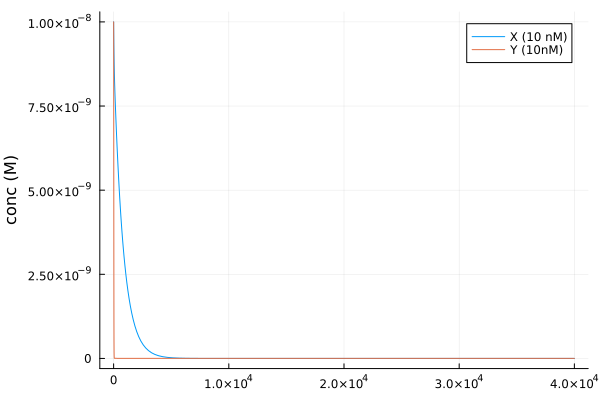

In [13]:
qmax = 1e5 # /M sec
k = 1e4 # scaled.
sigma = k

gamma_inv = qmax/(qmax-sigma) # 2
q = gamma_inv*k

xinit = 10*1e-9
yinit = 10*1e-9

Cmax = 200e-9 # 200nM

leak = 1
leak_rate = 1e-12
shadow = 1
ann = 1e6

u0 = [
xinit, Cmax, 0.0, Cmax, Cmax, 
0.0, Cmax, yinit, 0.0, 0.0, 
0.0, Cmax, Cmax, 
]

p = [q, qmax, leak, leak_rate, shadow, ann]

tspan = (0, 40000)
oprob = ODEProblem(bimol_rn, u0, tspan, p)
sol = solve(oprob, AutoTsit5(Rosenbrock23()), reltol=1e-12, abstol=1e-12)

xplot = aggregate_values(bimol_rn, sol, prefix="x")
yplot = aggregate_values(bimol_rn, sol, prefix="y")
t = sol.t
plot([t, t], [xplot, yplot], ylabel="conc (M)", 
    labels=["X (10 nM)" "Y (10nM)"], legend=:topright)

In [14]:
savefig("images/bimol_leaky_shadow.png")

"/Users/rajiv/Desktop/PhD/towardsCatalyticCRNs/julia-implementations/images/bimol_leaky_shadow.png"